# Loan Approval Classification — Notebook

Ce notebook effectue une Analyse Exploratoire des Données (Exploratory Data Analysis, EDA), le prétraitement, la sélection des features et propose différents modèles de classification des données.

## About Dataset
### 1. Data Source

This dataset is a synthetic version inspired by the original Credit Risk dataset on Kaggle and enriched with additional variables based on Financial Risk for Loan Approval data. SMOTENC was used to simulate new data points to enlarge the instances. The dataset is structured for both categorical and continuous features.

### 2. Metadata

Le dataset contient **45 000 observations** et **14 variables**.

#### Variables numériques (9)

| Variable | Description | Type |
|----------|-------------|------|
| `person_age` | Âge de la personne | Float |
| `person_income` | Revenu annuel | Float |
| `person_emp_exp` | Années d'expérience professionnelle | Integer |
| `loan_amnt` | Montant du prêt demandé | Float |
| `loan_int_rate` | Taux d'intérêt du prêt (%) | Float |
| `loan_percent_income` | Montant du prêt en % du revenu annuel | Float |
| `cb_person_cred_hist_length` | Durée de l'historique de crédit (années) | Float |
| `credit_score` | Score de crédit de la personne | Integer |
| **`loan_status`** *(target)* | **Statut d'approbation : 1 = approuvé, 0 = rejeté** | **Integer (binaire)** |

#### Variables catégorielles (5)

| Variable | Description | Modalités typiques |
|----------|-------------|-------------------|
| `person_gender` | Genre de la personne | Male, Female |
| `person_education` | Niveau d'éducation | High School, Bachelor, Master, Doctorate |
| `person_home_ownership` | Statut de propriété immobilière | Rent, Own, Mortgage, Other |
| `loan_intent` | Objectif du prêt | Education, Medical, Personal, Home Improvement, Debt Consolidation, Venture |
| `previous_loan_defaults_on_file` | Présence de défauts de paiement antérieurs | Yes, No |

### 3. Data Usage

The dataset can be used for multiple purposes:

- Exploratory Data Analysis (EDA): Analyze key features, distribution patterns, and relationships to understand credit risk factors.
- Classification: Build predictive models to classify the loan_status variable (approved/not approved) for potential applicants.
- Regression: Develop regression models to predict the credit_score variable based on individual and loan-related attributes.

Mind the data issue from the original data, such as the instance > 100-year-old as age.

This dataset provides a rich basis for understanding financial risk factors and simulating predictive modeling processes for loan approval and credit scoring.

## Contexte et objectifs

### Contexte

Ce notebook a pour but d'explorer un jeu de données de demandes de prêt, de préparer les données et d'entraîner des modèles de classification (Logistic Regression) pour prédire si un prêt est accordé (`loan_status`).

Étapes réalisées dans ce document :
- Chargement et vérification rapide des données
- Analyse exploratoire (EDA) des variables
- Rééquilibrage de la target (undersampling des classes majoritaires)
- Prétraitement (imputation, standardisation, encodage) via une pipeline
- Sélection simple de features (corrélation)
- Entraînement de pipeline avec GridSearchCV pour les différents modèles
- Évaluation et sauvegarde du modèle

### Objectifs

Les modèles de classification peuvent être évalués suivant plusieurs métriques. Les plus connues d'entre elles sont la précision et le rappel (precision and recall). Le F1-score est une combinaison des deux tel que :

$$F1 = \frac{2}{\frac{1}{\text{Precision}} + \frac{1}{\text{Recall}}}$$


$$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

Où :
- **Precision** = $\frac{TP}{TP + FP}$ (proportion de prédictions positives correctes)
- **Recall** = $\frac{TP}{TP + FN}$ (proportion de vrais positifs détectés)
- TP = True Positives, FP = False Positives, FN = False Negatives

Le F1-score est la moyenne harmonique de la précision et du rappel, et atteint sa meilleure valeur à 1 (perfection) et sa pire à 0.


##### Pourquoi utilise-t-on le F1 score dans notre cas ?

Pour la banque, le plus important est une garantie de remboursement du crédit accordé. Il faut donc un être strict sur l'accord de celui-ci. On doit donc avoir un recall élevé.

En revanche, d'un point de vue morale, pour des questions d'attractivité de clientelle, la banque se doit aussi d'accorder des prêts.

On doit donc avoir un équilibre entre le recall et la précision : les deux sont importants et doivent afficher des scores élevés.


#### Objectif de F1 score

Quantitativement, on peut considérer notre modèle comme intéressant si le F1 est supérieur à 0.90, score pour lequel les recall et precision sont tous les deux hauts, garantissant à la fois une sécurité d'emprunt et une facilité d'acès à celui-ci.

$$F1 > 0.90$$

In [ ]:
import os
import sys
import subprocess


def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Liste des packages requis
required_packages = [
    'numpy', 
    'pandas', 
    'matplotlib', 
    'seaborn', 
    'scikit-learn',
    'scipy',
    'xgboost',
    'lightgbm',
    'torch',
    'gdown',
    'joblib'
]

for package in required_packages:
    try:
        if package == 'scikit-learn':
            __import__('sklearn')
        elif package == 'torch':
            __import__('torch')
        else:
            __import__(package)
    except ImportError:
        print(f"Installation de {package}...")
        install_package(package)

# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scipy
from scipy.stats import chi2_contingency, ttest_ind

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score,
    precision_recall_curve, average_precision_score, PrecisionRecallDisplay,
    roc_curve, roc_auc_score, RocCurveDisplay
)

# Modèles de boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Pandas plotting
from pandas.plotting import scatter_matrix

%matplotlib inline

### Chargement des données

Cette cellule charge le fichier CSV. Vérifiez le chemin `DATA_PATH`. Après le chargement, on affiche la dimension globale (`df.shape`) et un aperçu (`df.head()`). Si le fichier n'est pas trouvé, la cellule lève une erreur pour vous alerter.

In [ ]:

# Obtenir le chemin du notebook
notebook_path = os.path.abspath('')
print(f"Répertoire actuel : {notebook_path}")

# Se placer dans le répertoire du notebook
os.chdir(notebook_path)
DATA_PATH = os.path.join(os.getcwd(),'loan_data.csv')
if not os.path.exists(DATA_PATH):
    import gdown
    # ID du fichier Google Drive (extrait du lien)
    file_id = '1aSRxZA8X0eRZAYoKwxuLLL98pBkmwc0Q'
    url = f'https://drive.google.com/uc?id={file_id}'
    
    # Télécharger le fichier
    gdown.download(url, DATA_PATH, quiet=False)
    
       
    
df = pd.read_csv(DATA_PATH)
print('Dimensions:', df.shape)
df.head()

### Inspection rapide des types et des valeurs manquantes

Cette cellule :
- affiche le résumé `df.info()` (types et valeurs non-null)
- compte les valeurs manquantes par colonne
- convertit `person_age` en entier si présent (attention : perte d'infos si valeurs non-integers)
- construit deux listes `cat_cols` et `num_cols` basées sur le dtype (utile pour l'EDA et la construction de transformers)

In [ ]:
# Aperçu rapide et types
display(df.info())
print('\nValeurs manquantes par colonne:\n', df.isnull().sum())
# convertir person_age si présent
if 'person_age' in df.columns:
    df['person_age'] = df['person_age'].astype(int)

# Détection simple des colonnes catégorielles vs numériques (basée sur dtype)
cat_cols = [c for c in df.columns if df[c].dtype == 'object']
num_cols = [c for c in df.columns if c not in cat_cols]
print('Colonnes catégorielles:', cat_cols)
print('Colonnes numériques:', num_cols)

### EDA : distributions et visualisations simples



In [ ]:
# EDA simple: distributions des catégorielles et des numériques
for c in cat_cols:
    plt.figure(figsize=(6,3))
    # value_counts() montre les modalités et leurs effectifs
    df[c].value_counts().plot(kind='bar', title=f'Repartition - {c}')
    plt.xlabel(c)
    plt.tight_layout()
    plt.show()

if num_cols:
    # histogrammes groupés pour repérer la forme des distributions
    df[num_cols].hist(bins=30, figsize=(12,8))
    plt.suptitle('Histogrammes des variables numériques')
    plt.show()

# Distribution de la target
if 'loan_status' in df.columns:
    counts = df['loan_status'].value_counts()
    plt.figure(figsize=(4,4))
    plt.pie(counts, labels=[str(i) + ' (' + str(n) + ')' for i,n in zip(counts.index, counts)], autopct='%.2f')
    plt.title('Proportion de loan_status')
    plt.show()


In [ ]:
df = df[df['person_age'] <= 75]

### Rééquilibrage de la target — pourquoi l'undersampling ?

Ici, nous choisissons d'équilibrer la target `loan_status` par undersampling des classes majoritaires (réduction du nombre d'exemples des classes abondantes) afin d'obtenir des classes approximativement équilibrées.

Points importants :
- L'undersampling évite d'ajouter des exemples synthétiques mais réduit la taille totale du jeu de données.
- Si la classe minoritaire est très petite, l'undersampling peut trop appauvrir l'entraînement.
- Alternative : l'upsampling, SMOTE, ou l'utilisation de `class_weight='balanced'` dans les modèles. On ne l'utilisera pas ici


In [ ]:
# Rééquilibrage de la target `loan_status` à ~50/50 via undersampling (suppression d'exemples des classes majoritaires)

print('Distribution avant (counts):')
print(df['loan_status'].value_counts(dropna=False))

counts = df['loan_status'].value_counts()
min_n = counts.min()
parts = []
for cls, n in counts.items():
    subset = df[df['loan_status'] == cls]
    if n > min_n:
        # Sous-échantillonnage de la classe majoritaire jusqu'à min_n (sans remplacement)
        subset = subset.sample(n=min_n, replace=False, random_state=42)
    parts.append(subset)
df = pd.concat(parts, axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
print('Distribution après (équilibrée):')
print(df['loan_status'].value_counts())


## Études des corrélations potentiels

Nous pouvons supposer que certains groupes sociaux sont plus enclins à avoir bénéficier d'accord pour un emprunt.

Par exemple, certains facteurs comme l'éducation, le montant emprunté, le montant par rapport au salaire, le score crédit de la personne peuvent directement avoir une influence sur l'emprunt.

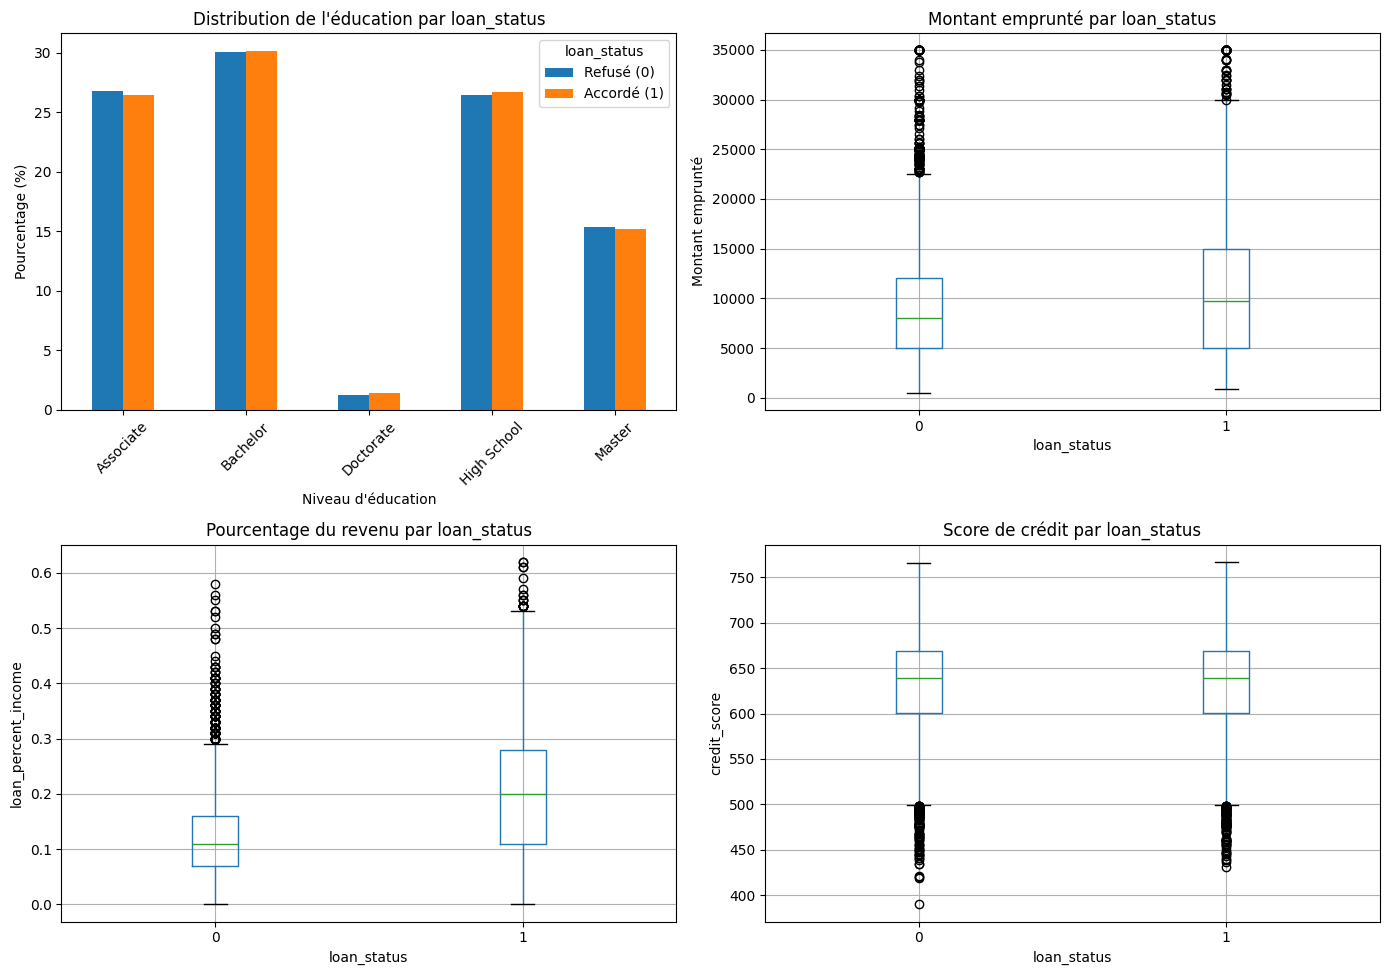

In [47]:
# Analyse de la corrélation entre loan_status et différentes variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Éducation vs loan_status
ax1 = axes[0, 0]
education_status = pd.crosstab(df['loan_status'], df['person_education'], normalize='index') * 100
education_status.T.plot(kind='bar', ax=ax1)
ax1.set_title('Distribution de l\'éducation par loan_status')
ax1.set_xlabel('Niveau d\'éducation')
ax1.set_ylabel('Pourcentage (%)')
ax1.legend(title='loan_status', labels=['Refusé (0)', 'Accordé (1)'])
ax1.tick_params(axis='x', rotation=45)

# 2. Montant emprunté vs loan_status
ax2 = axes[0, 1]
df.boxplot(column='loan_amnt', by='loan_status', ax=ax2)
ax2.set_title('Montant emprunté par loan_status')
ax2.set_xlabel('loan_status')
ax2.set_ylabel('Montant emprunté')
ax2.get_figure().suptitle('')

# 3. Pourcentage du revenu vs loan_status
ax3 = axes[1, 0]
df.boxplot(column='loan_percent_income', by='loan_status', ax=ax3)
ax3.set_title('Pourcentage du revenu par loan_status')
ax3.set_xlabel('loan_status')
ax3.set_ylabel('loan_percent_income')
ax3.get_figure().suptitle('')

# 4. Score de crédit vs loan_status
ax4 = axes[1, 1]
df.boxplot(column='credit_score', by='loan_status', ax=ax4)
ax4.set_title('Score de crédit par loan_status')
ax4.set_xlabel('loan_status')
ax4.set_ylabel('credit_score')
ax4.get_figure().suptitle('')

plt.tight_layout()
plt.show()

Pas vraiment de corrélation...

## Méthodes d'analyse de corrélation

Pour comprendre les relations entre les variables et la target `loan_status`, nous utilisons **trois approches complémentaires** permettant d'analyser respectivement les variables numériques et catégorielles.

---

### 1. Corrélation de Pearson (Variables numériques)

#### Définition

Le coefficient de corrélation de Pearson mesure l'intensité et la direction de la relation **linéaire** entre deux variables quantitatives.

#### Formule mathématique

$$r_{X,Y} = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}$$

**Où :**
- $r_{X,Y}$ : coefficient de corrélation de Pearson entre les variables X et Y
- $n$ : nombre d'observations
- $x_i$ : valeur de la variable X pour l'observation i
- $y_i$ : valeur de la variable Y pour l'observation i
- $\bar{x}$ : moyenne arithmétique de la variable X, calculée comme $\bar{x} = \frac{1}{n}\sum_{i=1}^{n}x_i$
- $\bar{y}$ : moyenne arithmétique de la variable Y, calculée comme $\bar{y} = \frac{1}{n}\sum_{i=1}^{n}y_i$

#### Interprétation des valeurs

| Valeur de r | Interprétation |
|-------------|----------------|
| r = 1 | Corrélation positive parfaite (relation linéaire croissante) |
| 0.7 ≤ r < 1 | Corrélation positive forte |
| 0.3 ≤ r < 0.7 | Corrélation positive modérée |
| 0 < r < 0.3 | Corrélation positive faible |
| r = 0 | Absence de corrélation linéaire |
| -0.3 < r < 0 | Corrélation négative faible |
| -0.7 < r ≤ -0.3 | Corrélation négative modérée |
| -1 < r ≤ -0.7 | Corrélation négative forte |
| r = -1 | Corrélation négative parfaite (relation linéaire décroissante) |

#### Hypothèses et limites

**Hypothèses :**
- Les deux variables doivent être quantitatives (continues ou discrètes)
- La relation entre les variables doit être linéaire
- Les données ne doivent pas présenter d'outliers extrêmes

**Limites importantes :**
- Ne détecte que les relations **linéaires** (relations non-linéaires ignorées)
- Sensible aux valeurs aberrantes qui peuvent fausser le coefficient
- Un coefficient de corrélation ne permet **pas** de conclure sur la causalité (corrélation ≠ causalité)
- Une corrélation nulle n'implique pas l'absence de relation (peut exister une relation non-linéaire)

#### Application dans notre étude

- **Heatmap** : visualisation globale des corrélations entre toutes les variables numériques du dataset
- **Corrélation avec loan_status** : identification des variables numériques les plus prédictives de l'approbation du prêt

---

### 2. Test du Chi² (χ²) - Variables catégorielles

#### Définition

Le test du Chi² d'indépendance est un test statistique permettant de déterminer si deux variables catégorielles sont indépendantes ou s'il existe une association significative entre elles.

#### Hypothèses statistiques

- **H₀** (hypothèse nulle) : les deux variables sont **indépendantes** (aucune association)
- **H₁** (hypothèse alternative) : les deux variables sont **dépendantes** (association significative)

#### Statistique de test

$$\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

**Où :**
- $\chi^2$ : statistique du Chi² calculée
- $r$ : nombre de lignes du tableau de contingence (nombre de modalités de la première variable)
- $c$ : nombre de colonnes du tableau de contingence (nombre de modalités de la seconde variable)
- $O_{ij}$ : fréquence **observée** dans la cellule (i, j), c'est-à-dire le nombre réel d'observations
- $E_{ij}$ : fréquence **attendue** dans la cellule (i, j) sous l'hypothèse d'indépendance

#### Calcul des fréquences attendues

Sous l'hypothèse d'indépendance (H₀), la fréquence attendue pour chaque cellule est calculée comme :

$$E_{ij} = \frac{(\text{total ligne } i) \times (\text{total colonne } j)}{\text{total général}}$$

Plus formellement :

$$E_{ij} = \frac{n_{i\cdot} \times n_{\cdot j}}{n}$$

**Où :**
- $n_{i\cdot}$ : somme marginale de la ligne i (total de la ligne)
- $n_{\cdot j}$ : somme marginale de la colonne j (total de la colonne)
- $n$ : effectif total (somme de toutes les observations)

#### Interprétation de la p-value

La p-value représente la probabilité d'observer une statistique χ² aussi extrême (ou plus) que celle calculée, si H₀ est vraie.

| p-value | Décision | Interprétation |
|---------|----------|----------------|
| p < 0.05 | Rejet de H₀ | Les variables sont significativement dépendantes (association statistiquement significative au seuil α = 5%) |
| p ≥ 0.05 | Non-rejet de H₀ | Pas de preuve suffisante d'une dépendance (les variables peuvent être considérées comme indépendantes) |

Note : Le seuil α = 0.05 est conventionnel mais peut être ajusté selon le contexte (0.01 ou 0.10).

#### Conditions d'application

- Les observations doivent être indépendantes
- Les effectifs attendus doivent être suffisamment grands : $E_{ij} \geq 5$ pour au moins 80% des cellules
- Si cette condition n'est pas respectée, utiliser le test exact de Fisher

#### Limites

- Le test du Chi² indique uniquement la **significativité** de l'association (existence d'un lien)
- Il ne mesure **pas l'intensité** de cette association
- Sensible à la taille de l'échantillon : avec un grand n, des associations faibles peuvent devenir significatives

---

### 3. Cramér's V - Intensité de l'association

#### Définition

Le V de Cramér est une mesure normalisée de l'intensité de l'association entre deux variables catégorielles. Il complète le test du Chi² en quantifiant la **force** de l'association détectée.

#### Formule de calcul

$$V = \sqrt{\frac{\chi^2}{n \times \min(r-1, c-1)}}$$

**Où :**
- $V$ : coefficient V de Cramér (compris entre 0 et 1)
- $\chi^2$ : statistique du Chi² calculée précédemment
- $n$ : nombre total d'observations
- $r$ : nombre de lignes du tableau de contingence
- $c$ : nombre de colonnes du tableau de contingence
- $\min(r-1, c-1)$ : le minimum entre (r-1) et (c-1), utilisé pour la normalisation

#### Interprétation des valeurs

| Valeur de V | Intensité de l'association |
|-------------|---------------------------|
| V = 0 | Aucune association (indépendance parfaite) |
| 0 < V < 0.1 | Association négligeable |
| 0.1 ≤ V < 0.3 | Association faible |
| 0.3 ≤ V < 0.5 | Association modérée |
| V ≥ 0.5 | Association forte |
| V = 1 | Association parfaite (dépendance complète) |

#### Avantages

- **Normalisation** : valeur comprise entre 0 et 1, permettant la comparaison entre différentes paires de variables
- **Interprétation intuitive** : plus V est élevé, plus l'association est forte
- **Complément du Chi²** : combine significativité (Chi²) et intensité (V de Cramér)

#### Différence avec le Chi²

| Critère | Chi² (p-value) | V de Cramér |
|---------|----------------|-------------|
| Nature | Test d'hypothèse | Mesure d'association |
| Réponse | Existe-t-il une association ? (oui/non) | Quelle est l'intensité de l'association ? |
| Interprétation | Significativité statistique | Force de la relation |
| Sensibilité à n | Très sensible (augmente avec n) | Peu sensible (normalisé) |

---

### Synthèse méthodologique

| Méthode | Type de variables | Ce qu'elle mesure | Valeur critique | Interprétation |
|---------|-------------------|-------------------|-----------------|----------------|
| **Pearson (r)** | Numérique ↔ Numérique | Force et direction de la relation linéaire | \|r\| > 0.5 | Forte corrélation linéaire |
| **Chi² (p-value)** | Catégorielle ↔ Catégorielle | Significativité statistique de la dépendance | p < 0.05 | Association statistiquement significative |
| **Cramér's V** | Catégorielle ↔ Catégorielle | Intensité de l'association | V > 0.3 | Association modérée à forte |

---

### Application au contexte bancaire

Dans notre étude de prédiction d'approbation de prêt, ces méthodes permettent d'identifier :

**Variables numériques (Pearson) :**
- Corrélation entre `credit_score` et `loan_status`
- Relation entre `loan_amnt` et `person_income`
- Impact de `loan_percent_income` sur l'approbation

**Variables catégorielles (Chi² et Cramér's V) :**
- Association entre `person_education` et `loan_status`
- Lien entre `loan_intent` et l'approbation du prêt
- Influence du `person_home_ownership` sur la décision

Cette analyse multidimensionnelle permet de sélectionner les features les plus pertinentes pour la modélisation prédictive.



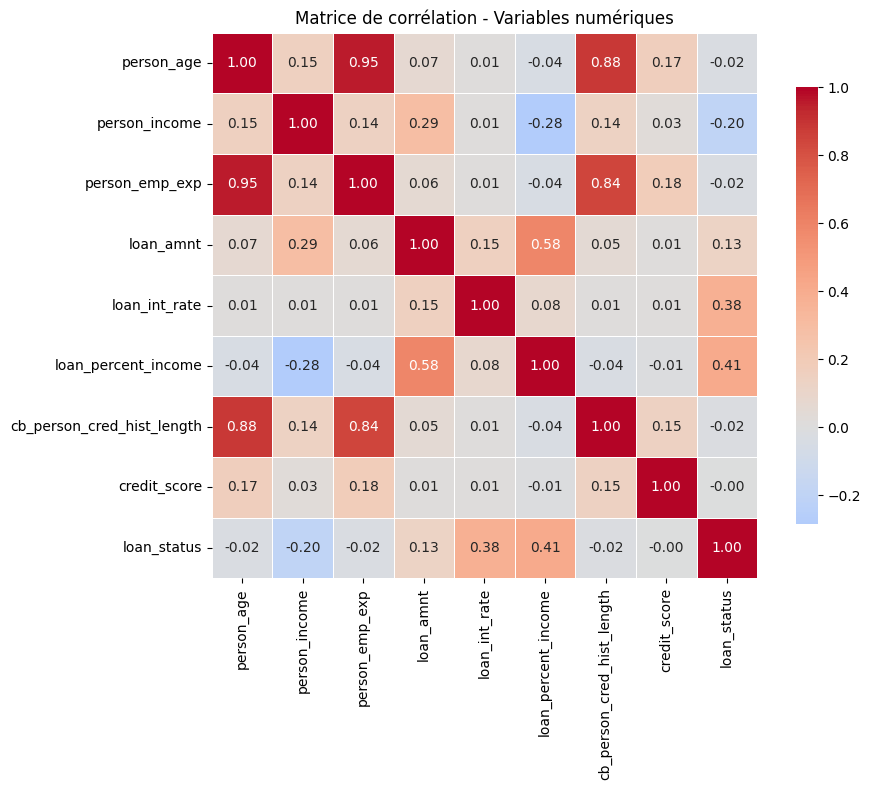

In [48]:
## Analyse des corrélations

import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))

# Heatmap de corrélation (variables numériques)
correlation_matrix = df[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, ax=ax, cbar_kws={"shrink": 0.8})
ax.set_title('Matrice de corrélation - Variables numériques', fontsize=12)

plt.tight_layout()
plt.show()

array([[<Axes: xlabel='person_age', ylabel='person_age'>,
        <Axes: xlabel='person_emp_exp', ylabel='person_age'>],
       [<Axes: xlabel='person_age', ylabel='person_emp_exp'>,
        <Axes: xlabel='person_emp_exp', ylabel='person_emp_exp'>]],
      dtype=object)

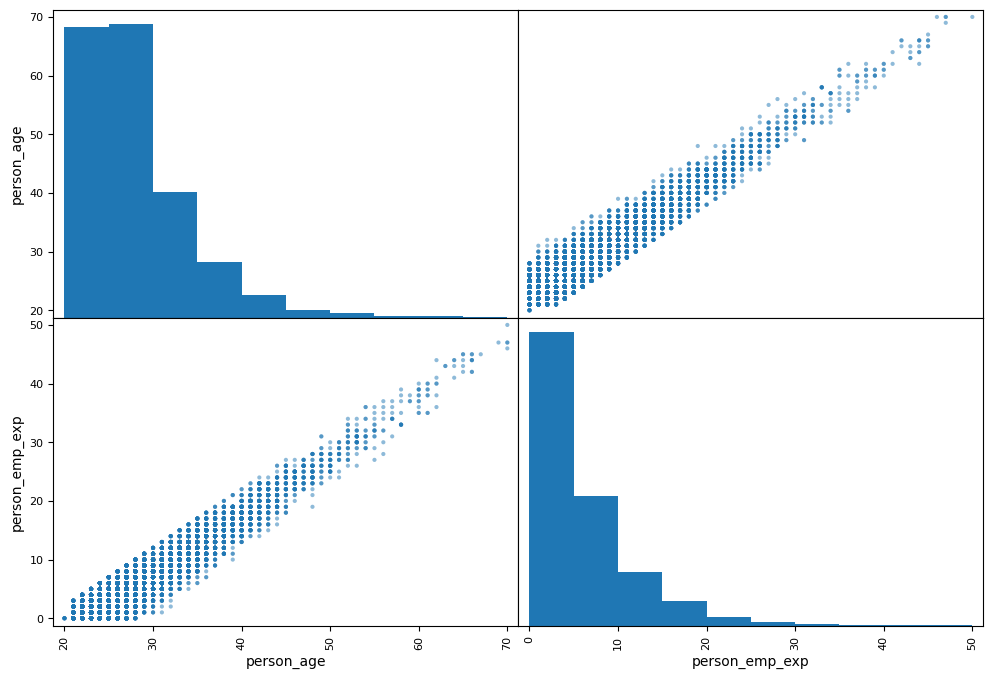

In [49]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[["person_age", "person_emp_exp"]], figsize=(12,8))

C'est normal, il est logique que, plus une personne vieillisse, plus elle travaille. Il en est de même pour les deux autres corrélations croissante.


 Corrélation des variables numériques avec loan_status:
loan_status                   1.000000
loan_percent_income           0.409367
loan_int_rate                 0.381542
loan_amnt                     0.128422
credit_score                 -0.002629
cb_person_cred_hist_length   -0.020228
person_emp_exp               -0.022808
person_age                   -0.024143
person_income                -0.202925


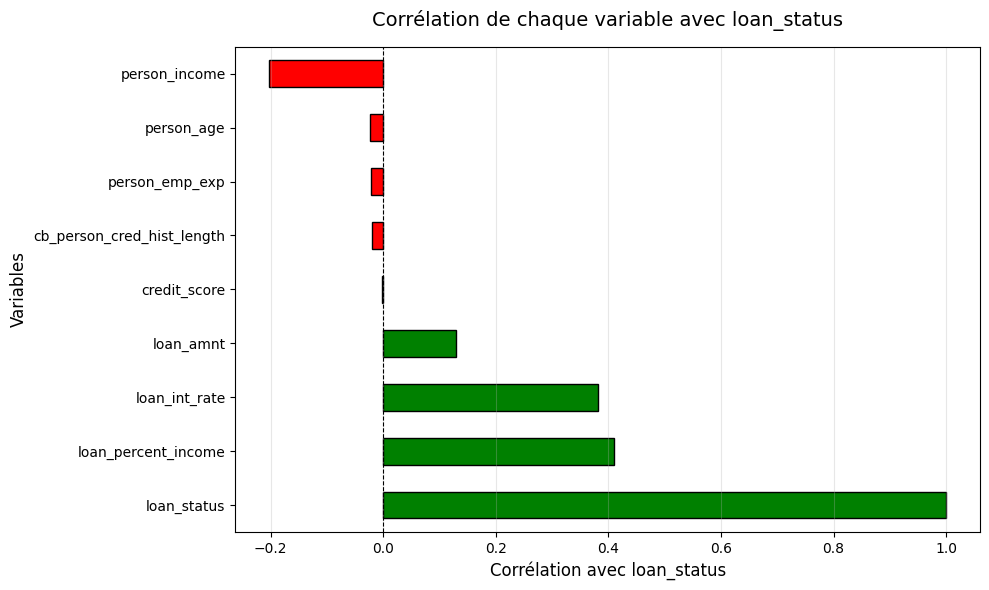

In [50]:
### 2. Corrélation avec loan_status uniquement

# Calculer la corrélation de toutes les variables numériques avec loan_status
correlations_with_target = df[num_cols].corrwith(df['loan_status']).sort_values(ascending=False)

# Afficher le tableau
print("\n Corrélation des variables numériques avec loan_status:")
print(correlations_with_target.to_string())

# Visualisation en barplot
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in correlations_with_target.values]
correlations_with_target.plot(kind='barh', color=colors, edgecolor='black')
plt.xlabel('Corrélation avec loan_status', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.title('Corrélation de chaque variable avec loan_status', fontsize=14, pad=15)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


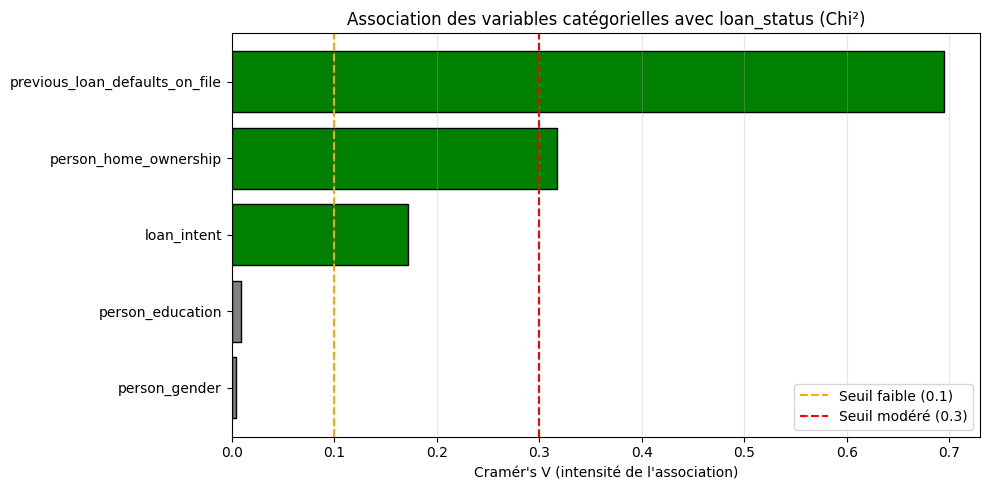


 RÉSULTATS DU TEST CHI²
                      Variable        Chi²       p-value  Cramér V Significatif
                 person_gender    0.291664  5.891559e-01  0.003819          Non
              person_education    1.595545  8.095926e-01  0.008932          Non
                   loan_intent  592.853879 7.077046e-126  0.172171          Oui
         person_home_ownership 2012.039652  0.000000e+00  0.317178          Oui
previous_loan_defaults_on_file 9666.221856  0.000000e+00  0.695206          Oui

Interprétation: Vert = significatif (p < 0.05), Gris = non significatif


In [51]:
### Test du Chi² et Cramér's V pour variables catégorielles

from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Calcul des résultats
chi2_results = []
for cat_var in cat_cols:
    if cat_var != 'loan_status':
        contingency_table = pd.crosstab(df[cat_var], df['loan_status'])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
        chi2_results.append({
            'Variable': cat_var, 'Chi²': chi2, 'p-value': p_value, 
            'Cramér V': cramers_v, 'Significatif': 'Oui' if p_value < 0.05 else 'Non'
        })

chi2_df = pd.DataFrame(chi2_results).sort_values('Cramér V', ascending=True)

# Visualisation unique
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['green' if p < 0.05 else 'gray' for p in chi2_df['p-value']]
ax.barh(chi2_df['Variable'], chi2_df['Cramér V'], color=colors, edgecolor='black')
ax.axvline(x=0.1, color='orange', linestyle='--', label='Seuil faible (0.1)')
ax.axvline(x=0.3, color='red', linestyle='--', label='Seuil modéré (0.3)')
ax.set_xlabel("Cramér's V (intensité de l'association)")
ax.set_title("Association des variables catégorielles avec loan_status (Chi²)")
ax.legend()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Tableau récapitulatif
print("\n RÉSULTATS DU TEST CHI²")
print("="*70)
print(chi2_df.to_string(index=False))
print("\nInterprétation: Vert = significatif (p < 0.05), Gris = non significatif")

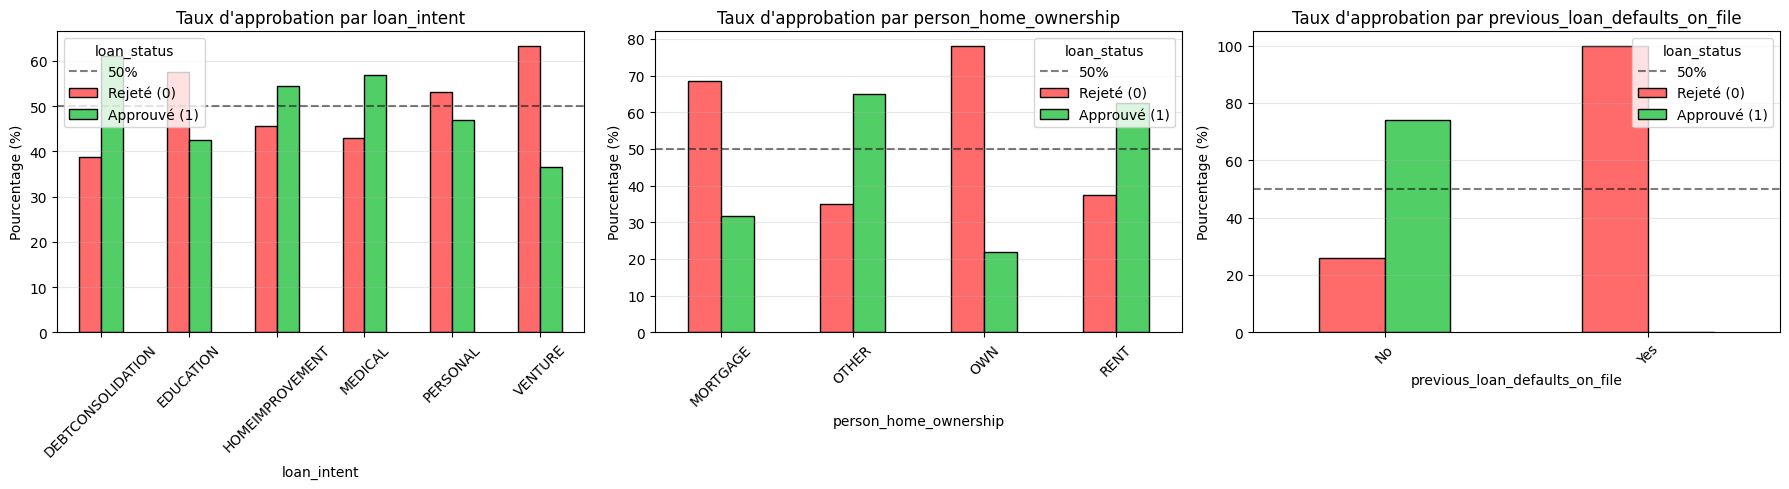

In [52]:
### Analyse des variables catégorielles significatives

significant_categorical_vars = chi2_df[chi2_df['p-value'] < 0.05]['Variable'].tolist()

if significant_categorical_vars:
    fig, axes = plt.subplots(1, len(significant_categorical_vars), figsize=(6*len(significant_categorical_vars), 5))
    if len(significant_categorical_vars) == 1:
        axes = [axes]
    
    for ax, cat_var in zip(axes, significant_categorical_vars):
        # Tableau croisé : pour chaque modalité de cat_var, % de loan_status=0 et loan_status=1
        contingency_pct = pd.crosstab(df[cat_var], df['loan_status'], normalize='index') * 100
        
        # Renommer les colonnes pour plus de clarté
        contingency_pct.columns = ['Rejeté (0)', 'Approuvé (1)']
        
        # Tracer avec les bonnes couleurs : Rouge pour rejeté, Vert pour approuvé
        contingency_pct.plot(kind='bar', ax=ax, color=['#ff6b6b', '#51cf66'], edgecolor='black')
        
        ax.set_title(f'Taux d\'approbation par {cat_var}')
        ax.set_xlabel(cat_var)
        ax.set_ylabel('Pourcentage (%)')
        ax.axhline(y=50, color='black', linestyle='--', alpha=0.5, label='50%')
        ax.legend(title='loan_status')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Aucune variable catégorielle significative détectée.")

In [53]:
# Prétraitement général: imputation/scale/OHE via ColumnTransformer
# construire X et y en incluant les colonnes clean
cols_keep = [c for c in df.columns if c != 'loan_status']
X = df[cols_keep].copy()
y = df['loan_status'].copy()


# Séparation des données numériques et catégorielles
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
print('num_cols:', num_cols)
print('cat_cols:', cat_cols)

numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num', numeric_transformer, num_cols), ('cat', categorical_transformer, cat_cols)])

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape)

num_cols: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']
cat_cols: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Train/Test shapes: (16000, 13) (4000, 13)


# Modèles

## Introduction des données d'entraînement et d'évaluation

Les variables globales d'entraînement et d'évaluation sont :
* X_train, y_train
* X_test, y_test

## Dernière visualisation des données


In [54]:
Visualiser = X_train.copy()
Visualiser ['label_loan_status'] = y_train
Visualiser.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,label_loan_status
7017,24,male,High School,16470.0,2,MORTGAGE,4500.0,DEBTCONSOLIDATION,11.83,0.27,4.0,643,No,1
9135,31,male,Associate,50885.0,7,RENT,7750.0,EDUCATION,16.45,0.15,7.0,679,Yes,0
10090,23,male,Bachelor,43398.0,2,MORTGAGE,3000.0,MEDICAL,11.28,0.07,3.0,618,Yes,0
3614,23,male,Associate,30034.0,2,RENT,2700.0,DEBTCONSOLIDATION,10.75,0.09,2.0,599,No,1
19922,47,male,Master,46967.0,27,RENT,22000.0,MEDICAL,18.78,0.47,17.0,661,No,1


## 1. Modèles Linéraires

### Logisitic Regression

Quelques commentaires : le C apparait dans la fonction coût, le modèle réalise ici une régression linéaire classique et utilise la fonction sigmoïde pour limiter les résultats à la plage [0;1], le seuil de classification est de 0.5.


In [55]:
pipe = Pipeline([('preprocessor', preprocessor), 
                 ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))])
param_grid = {'clf__C': [0.01, 0.1, 1.0, 10.0, 100.0, 200.0, 400.0, 700.0, 1000.0]}
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)
print('Best params:', gs.best_params_)
best_lr = gs.best_estimator_

# évaluer sur test
y_pred = best_lr.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred))

Best params: {'clf__C': 10.0}
Test accuracy: 0.86825

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      2000
           1       0.84      0.91      0.87      2000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000



#### Observation des CV de chaque C

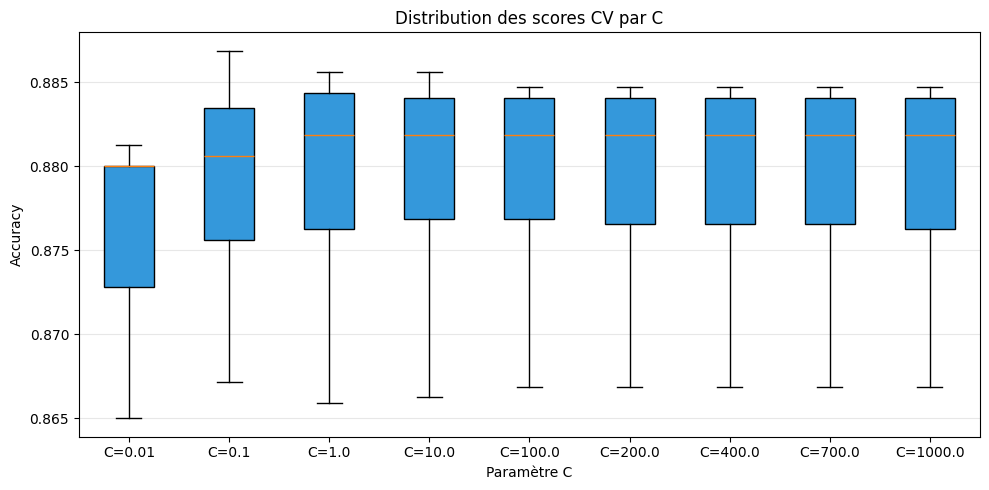

LOGISTIC REGRESSION - GRIDSEARCH CV RESULTS
Paramètres testés: C = [np.float64(0.01), np.float64(0.1), np.float64(1.0), np.float64(10.0), np.float64(100.0), np.float64(200.0), np.float64(400.0), np.float64(700.0), np.float64(1000.0)]

C          Mean       Std        Min        Max       
----------------------------------------------------------------------
0.01       0.8758     0.0062     0.8650     0.8812    
0.10       0.8787     0.0069     0.8672     0.8869    
1.00       0.8788     0.0072     0.8659     0.8856    
10.00      0.8789     0.0070     0.8662     0.8856    
100.00     0.8789     0.0066     0.8669     0.8847    
200.00     0.8788     0.0066     0.8669     0.8847    
400.00     0.8788     0.0066     0.8669     0.8847    
700.00     0.8788     0.0066     0.8669     0.8847    
1000.00    0.8787     0.0066     0.8669     0.8847    


In [56]:
cv_results_lr = pd.DataFrame(gs.cv_results_)
c_values = sorted(cv_results_lr['param_clf__C'].unique())

# Box plot comparatif
fig, ax = plt.subplots(figsize=(10, 5))
data_to_plot = [[cv_results_lr[cv_results_lr['param_clf__C'] == c].iloc[0][f'split{i}_test_score'] 
                  for i in range(5)] for c in c_values]
bp = ax.boxplot(data_to_plot, labels=[f'C={c}' for c in c_values], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#3498db')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Paramètre C')
ax.set_title('Distribution des scores CV par C')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Tableau récapitulatif
print("LOGISTIC REGRESSION - GRIDSEARCH CV RESULTS")
print("="*70)
print(f"Paramètres testés: C = {c_values}")
print(f"\n{'C':<10} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
print("-"*70)
for c_val in c_values:
    row = cv_results_lr[cv_results_lr['param_clf__C'] == c_val].iloc[0]
    fold_scores = [row[f'split{i}_test_score'] for i in range(5)]
    print(f"{c_val:<10.2f} {row['mean_test_score']:<10.4f} {row['std_test_score']:<10.4f} "
          f"{min(fold_scores):<10.4f} {max(fold_scores):<10.4f}")

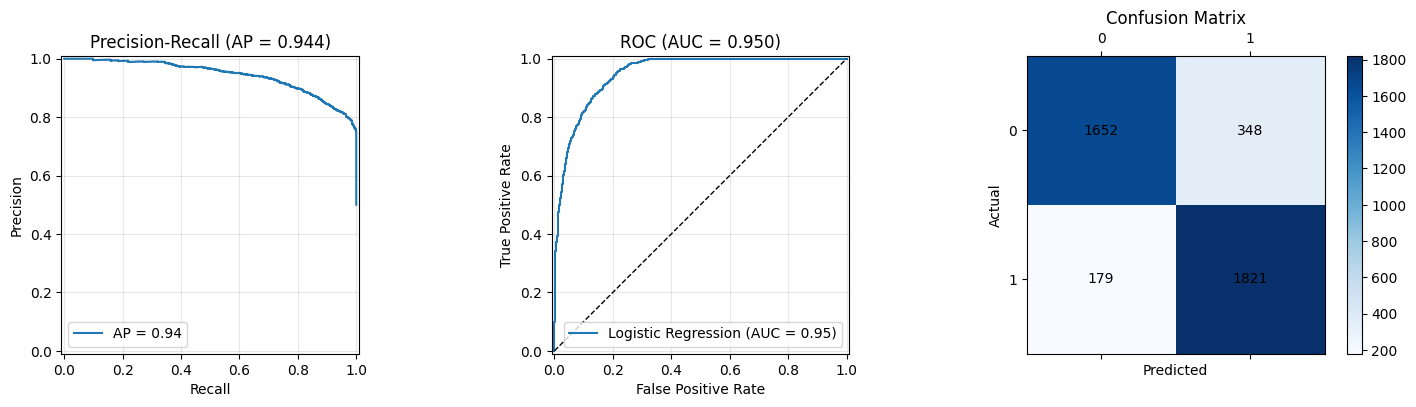

In [57]:
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, PrecisionRecallDisplay,
    roc_curve, roc_auc_score, RocCurveDisplay,
    confusion_matrix
)

# Calculer les probabilités prédites
y_proba = best_lr.predict_proba(X_test)[:, 1]

# Créer les 3 graphiques
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Courbe Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
display_pr = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap)
display_pr.plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP = {ap:.3f})')
axes[0].grid(alpha=0.3)

# 2. Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display_roc.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC = {roc_auc:.3f})')
axes[1].grid(alpha=0.3)

# 3. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
cax = axes[2].matshow(cm, cmap='Blues')
for (i, j), val in np.ndenumerate(cm):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.tight_layout()
plt.show()

#### Analyse des coefficients et calibration

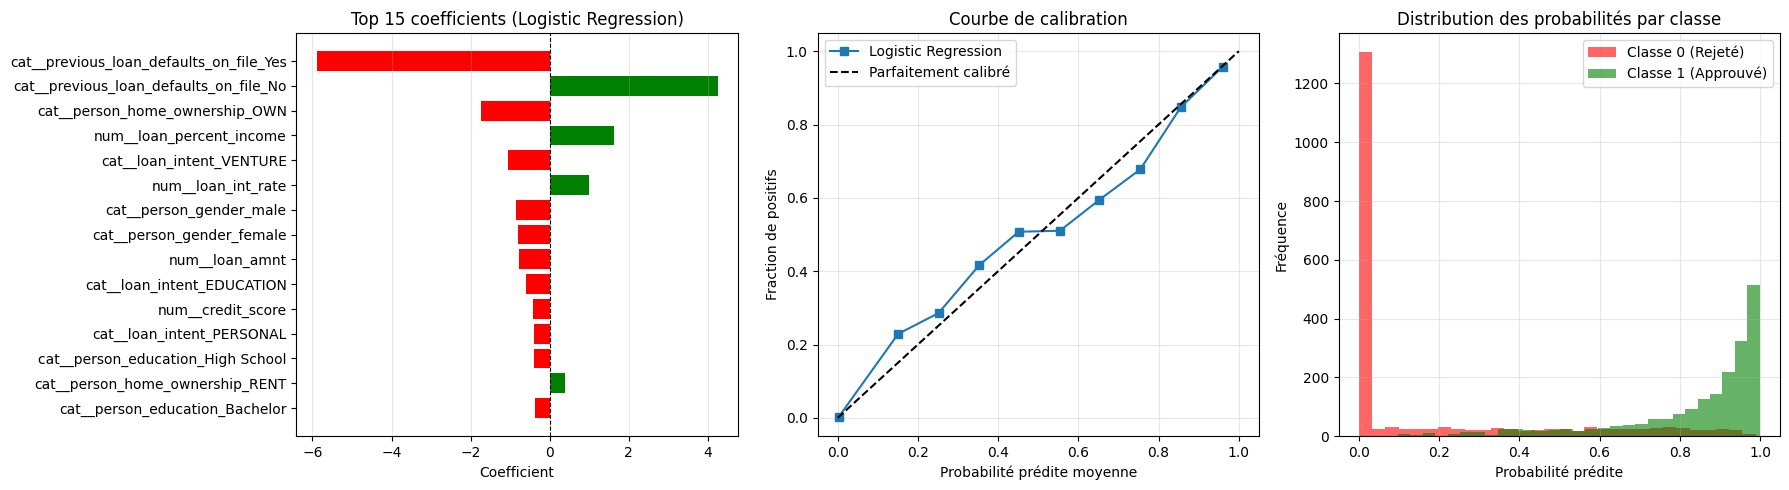

In [58]:
from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

coefs = best_lr.named_steps['clf'].coef_[0]
feature_names = best_lr.named_steps['preprocessor'].get_feature_names_out()
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefs})
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=True).tail(15)

axes[0].barh(coef_df['feature'], coef_df['coefficient'], color=['green' if c > 0 else 'red' for c in coef_df['coefficient']])
axes[0].set_xlabel('Coefficient')
axes[0].set_title('Top 15 coefficients (Logistic Regression)')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].grid(axis='x', alpha=0.3)

prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
axes[1].plot(prob_pred, prob_true, 's-', label='Logistic Regression')
axes[1].plot([0, 1], [0, 1], 'k--', label='Parfaitement calibré')
axes[1].set_xlabel('Probabilité prédite moyenne')
axes[1].set_ylabel('Fraction de positifs')
axes[1].set_title('Courbe de calibration')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].hist(y_proba[y_test == 0], bins=30, alpha=0.6, label='Classe 0 (Rejeté)', color='red')
axes[2].hist(y_proba[y_test == 1], bins=30, alpha=0.6, label='Classe 1 (Approuvé)', color='green')
axes[2].set_xlabel('Probabilité prédite')
axes[2].set_ylabel('Fréquence')
axes[2].set_title('Distribution des probabilités par classe')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Interprétation du modèle de régression logistique

### 1. Analyse des coefficients

Les coefficients de la régression logistique indiquent l'influence de chaque variable sur la probabilité d'approbation du prêt :

- **Coefficients positifs (vert)** : augmentent la probabilité de `loan_status = 1` (prêt approuvé)
- **Coefficients négatifs (rouge)** : diminuent la probabilité d'approbation

La valeur absolue du coefficient reflète l'**intensité** de l'influence. Les variables avec les plus grands coefficients absolus sont les plus déterminantes dans la décision du modèle.

### 2. Courbe de calibration

La courbe de calibration compare les probabilités prédites aux fréquences réelles observées :

- **Courbe proche de la diagonale** : le modèle est bien calibré (une probabilité prédite de 0.7 correspond effectivement à 70% de positifs)
- **Courbe au-dessus de la diagonale** : le modèle sous-estime les probabilités
- **Courbe en-dessous de la diagonale** : le modèle surestime les probabilités

Un modèle bien calibré est essentiel pour prendre des décisions fiables basées sur les probabilités.

### 3. Distribution des probabilités

L'histogramme montre comment le modèle sépare les deux classes :

- **Bonne séparation** : les distributions sont distinctes avec peu de chevauchement
- **Mauvaise séparation** : fort chevauchement, le modèle a du mal à distinguer les classes

Une séparation nette indique que le problème est intrinsèquement **linéairement séparable**, expliquant les bonnes performances d'un modèle simple comme la régression logistique.

## Modélisation pour Random Forest : preprocessing et gridsearch

* Le nombre de cas possible étant trop grand, l'entrainement du modèle avec un algorithme d'optimisation glouton est trop lent, on teste donc deux autres méthodes : RandomizedSeachCV et HalvingGridSearchCV pour random forest et extra tree classifier

## Random Forest

Random Forest est un algorithme d'ensemble basé sur la méthode des arbres de décision. Il construit plusieurs arbres de décision indépendants sur des sous-échantillons bootstrap du jeu de données d'entraînement, puis agrège leurs prédictions par vote majoritaire pour la classification. Chaque arbre est entraîné sur un sous-ensemble aléatoire des features pour introduire de la diversité.

**Formule de prédiction pour la classification :**

$$
\hat{y} = \arg\max_k \sum_{t=1}^T I(\hat{y}^{(t)} = k)
$$

où $T$ est le nombre d'arbres, $\hat{y}^{(t)}$ est la prédiction du $t$-ième arbre pour la classe $k$, et $I$ est la fonction indicatrice.

**Critère de division (Gini) :**

$$
\text{Gini} = 1 - \sum_{k=1}^K p_k^2
$$

où $p_k$ est la proportion d'échantillons de classe $k$ dans le nœud.

**Réduction de variance :**

$$
\text{Var}(\hat{y}) = \frac{1}{T} \text{Var}(\hat{y}^{(t)}) + \frac{T-1}{T} \text{Cov}(\hat{y}^{(t)}, \hat{y}^{(t')})
$$

L'agrégation réduit la variance tout en maintenant un faible biais.

In [59]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

pipe_rf = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

param_dist_rf = {
    'clf__n_estimators': [300, 500],
    'clf__max_depth': [10, 20, 30, 50, 70],
    'clf__min_samples_split': [2, 3, 5, 7, 8],
}

rs_rf = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=param_dist_rf,
    n_iter=50, 
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)


rs_rf.fit(X_train, y_train)

best_idx = rs_rf.best_index_
cv_results = rs_rf.cv_results_

fold_scores = [cv_results[f'split{i}_test_score'][best_idx] for i in range(5)]
mean_score = cv_results['mean_test_score'][best_idx]
std_score = cv_results['std_test_score'][best_idx]

print(f"Meilleurs paramètres: {rs_rf.best_params_}")
print(f"\nRésultats CV (F1-score) :")
for i, score in enumerate(fold_scores):
    print(f"  Fold {i+1}: {score:.4f}")
print(f"\nMoyenne: {mean_score:.4f}")
print(f"Écart-type: {std_score:.4f}")

best_rf = rs_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

print(f'\nMétriques test:')
print(f'Accuracy : {accuracy_score(y_test, y_pred_rf):.4f}')
print(f'F1-score : {f1_score(y_test, y_pred_rf):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_rf):.4f}')
print(f'Recall   : {recall_score(y_test, y_pred_rf):.4f}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs paramètres: {'clf__n_estimators': 500, 'clf__min_samples_split': 3, 'clf__max_depth': 20}

Résultats CV (F1-score) :
  Fold 1: 0.9001
  Fold 2: 0.9041
  Fold 3: 0.8975
  Fold 4: 0.9023
  Fold 5: 0.9028

Moyenne: 0.9014
Écart-type: 0.0023

Métriques test:
Accuracy : 0.8942
F1-score : 0.8968
Precision: 0.8757
Recall   : 0.9190


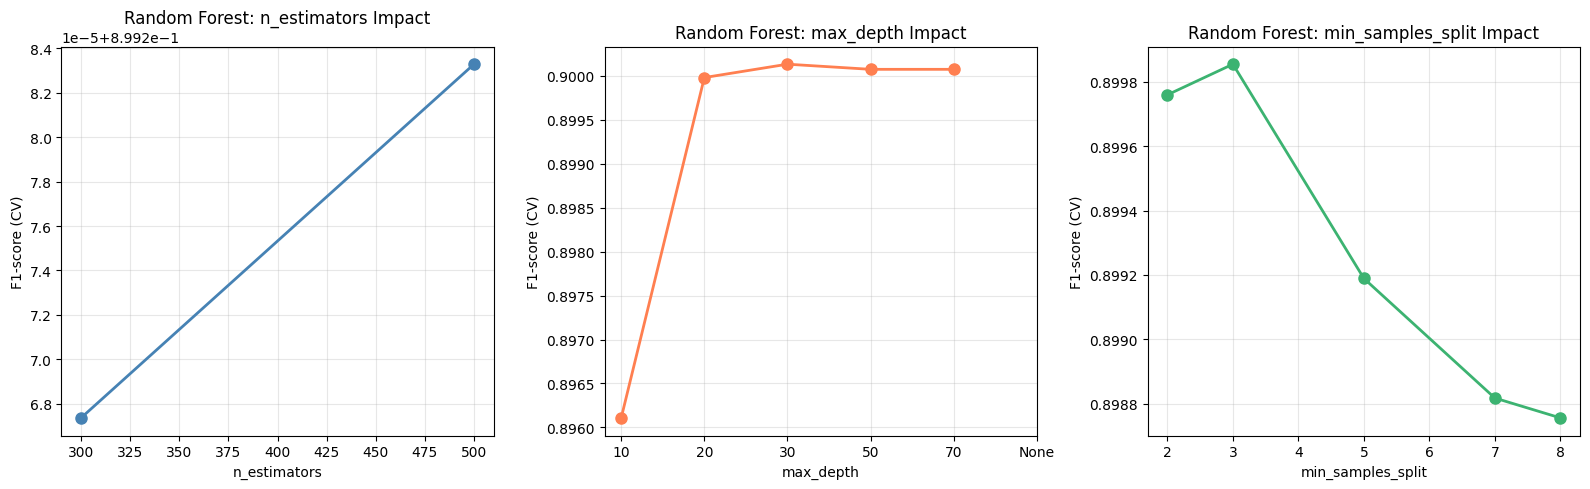

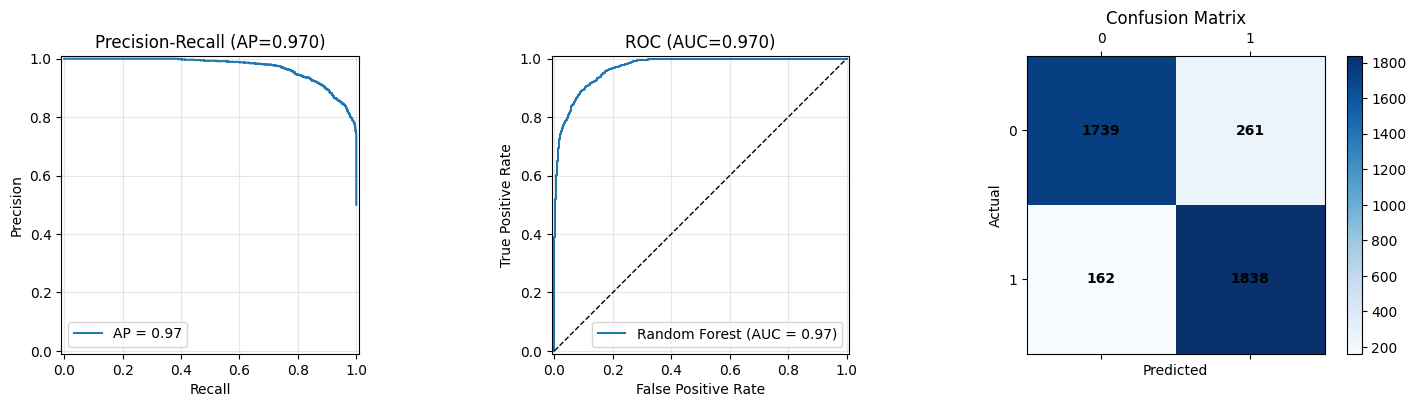

In [60]:
cv_results_rf = pd.DataFrame(rs_rf.cv_results_)

n_ests = sorted(cv_results_rf['param_clf__n_estimators'].unique())
max_depths = sorted([x for x in cv_results_rf['param_clf__max_depth'].unique() if x is not None]) + [None]
min_splits = sorted(cv_results_rf['param_clf__min_samples_split'].unique())

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

ax1 = axes[0]
means_n = []
for n_est in n_ests:
    mask = cv_results_rf['param_clf__n_estimators'] == n_est
    data = cv_results_rf[mask]['mean_test_score'].values
    means_n.append(data.mean())

ax1.plot(n_ests, means_n, 'o-', linewidth=2, markersize=8, color='steelblue')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('F1-score (CV)')
ax1.set_title('Random Forest: n_estimators Impact')
ax1.grid(alpha=0.3)

ax2 = axes[1]
means_d = []
depth_labels = []
for max_depth in max_depths:
    mask = cv_results_rf['param_clf__max_depth'] == max_depth
    data = cv_results_rf[mask]['mean_test_score'].values
    means_d.append(data.mean())
    depth_labels.append(str(max_depth) if max_depth is not None else 'None')

x_pos = range(len(max_depths))
ax2.plot(x_pos, means_d, 'o-', linewidth=2, markersize=8, color='coral')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(depth_labels)
ax2.set_xlabel('max_depth')
ax2.set_ylabel('F1-score (CV)')
ax2.set_title('Random Forest: max_depth Impact')
ax2.grid(alpha=0.3)

ax3 = axes[2]
means_m = []
for min_split in min_splits:
    mask = cv_results_rf['param_clf__min_samples_split'] == min_split
    data = cv_results_rf[mask]['mean_test_score'].values
    means_m.append(data.mean())

ax3.plot(min_splits, means_m, 'o-', linewidth=2, markersize=8, color='mediumseagreen')
ax3.set_xlabel('min_samples_split')
ax3.set_ylabel('F1-score (CV)')
ax3.set_title('Random Forest: min_samples_split Impact')
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

precision, recall, _ = precision_recall_curve(y_test, y_proba_rf)
ap = average_precision_score(y_test, y_proba_rf)
display_pr = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap)
display_pr.plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP={ap:.3f})')
axes[0].grid(alpha=0.3)

fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = roc_auc_score(y_test, y_proba_rf)
display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
display_roc.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC={roc_auc:.3f})')
axes[1].grid(alpha=0.3)

cm_rf = confusion_matrix(y_test, y_pred_rf)
cax = axes[2].matshow(cm_rf, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_rf):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.tight_layout()
plt.show()

## Modélisation pour ExtraTreesClassifier

## Extra Trees (Extremely Randomized Trees)

Extra Trees est une variante de Random Forest qui introduit plus de randomisation dans la construction des arbres. Contrairement à Random Forest, les seuils de division sont choisis aléatoirement plutôt que de manière optimale, ce qui accélère l'entraînement et réduit le surapprentissage.

**Formule de prédiction :**

$$
\hat{y} = \arg\max_k \sum_{i=1}^T I(\hat{y}_i^{(t)} = k)
$$

Identique à Random Forest, utilisant le vote majoritaire des $T$ arbres.

**Critère de division :**

Au lieu d'optimiser le critère de Gini ou d'entropie, les seuils sont tirés uniformément dans l'intervalle des valeurs des features :

$$
\text{threshold} \sim \mathcal{U}(\min(X_j), \max(X_j))
$$

où $X_j$ est la $j$-ième feature.

**Avantage mathématique :**

La randomisation accrue conduit à une variance plus faible :

$$
\text{Var}(\text{ET}) < \text{Var}(\text{RF})
$$

en raison de l'indépendance plus forte entre les arbres.

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 500
max_resources_: 16000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 40
n_resources: 500
Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------
iter: 1
n_candidates: 20
n_resources: 1000
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 2
n_candidates: 10
n_resources: 2000
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 3
n_candidates: 5
n_resources: 4000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 3
n_resources: 8000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 5
n_candidates: 2
n_resources: 16000
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params: {'clf__max_depth': 90, 'clf__min_samples_split': 7, 'clf__n_estimators': 300}
Test accuracy: 0.879
Test F1-score: 0.8848167539267016
Test Precision: 0.84

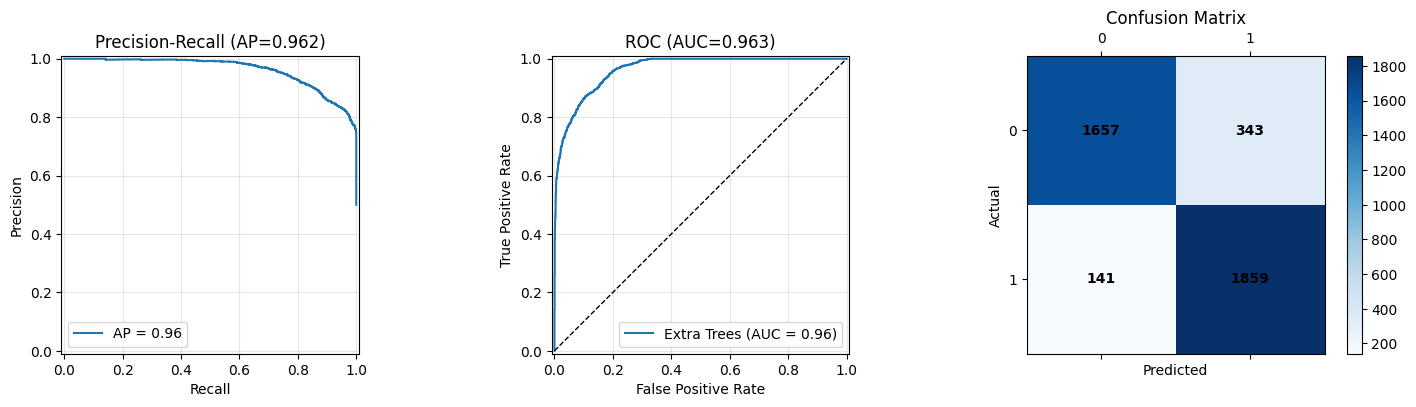

In [61]:
from sklearn.experimental import enable_halving_search_cv  # Active la fonctionnalité expérimentale
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

pipe_etc = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', ExtraTreesClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

param_grid_etc = {
    'clf__n_estimators': [300, 500],
    'clf__max_depth': [10, 20, 50, 70, 90],
    'clf__min_samples_split': [2, 5, 7, 10]
}

hgs_etc = HalvingGridSearchCV(
    pipe_etc,
    param_grid=param_grid_etc,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    factor=2,
    random_state=42
)

hgs_etc.fit(X_train, y_train)

print('Best params:', hgs_etc.best_params_)
best_etc = hgs_etc.best_estimator_

y_pred_etc = best_etc.predict(X_test)
y_proba_etc = best_etc.predict_proba(X_test)[:, 1]

print('Test accuracy:', accuracy_score(y_test, y_pred_etc))
print('Test F1-score:', f1_score(y_test, y_pred_etc))
print('Test Precision:', precision_score(y_test, y_pred_etc))
print('Test Recall:', recall_score(y_test, y_pred_etc))
print('\nClassification report:\n', classification_report(y_test, y_pred_etc))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

precision, recall, _ = precision_recall_curve(y_test, y_proba_etc)
ap = average_precision_score(y_test, y_proba_etc)
display_pr = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap)
display_pr.plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP={ap:.3f})')
axes[0].grid(alpha=0.3)

fpr, tpr, _ = roc_curve(y_test, y_proba_etc)
roc_auc = roc_auc_score(y_test, y_proba_etc)
display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Extra Trees')
display_roc.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC={roc_auc:.3f})')
axes[1].grid(alpha=0.3)

cm_etc = confusion_matrix(y_test, y_pred_etc)
cax = axes[2].matshow(cm_etc, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_etc):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.tight_layout()
plt.show()

Top 20 features les plus importantes (ExtraTreesClassifier) :
                                feature  importance
 cat__previous_loan_defaults_on_file_No    0.277173
cat__previous_loan_defaults_on_file_Yes    0.275675
                     num__loan_int_rate    0.082762
               num__loan_percent_income    0.075244
        cat__person_home_ownership_RENT    0.043281
                     num__person_income    0.039388
    cat__person_home_ownership_MORTGAGE    0.028353
                         num__loan_amnt    0.026342
                      num__credit_score    0.021631
                        num__person_age    0.016727
        num__cb_person_cred_hist_length    0.015773
                    num__person_emp_exp    0.015768
               cat__loan_intent_VENTURE    0.010190
         cat__person_home_ownership_OWN    0.009271
     cat__loan_intent_DEBTCONSOLIDATION    0.007414
               cat__loan_intent_MEDICAL    0.007130
        cat__person_education_Associate    0.005550
  

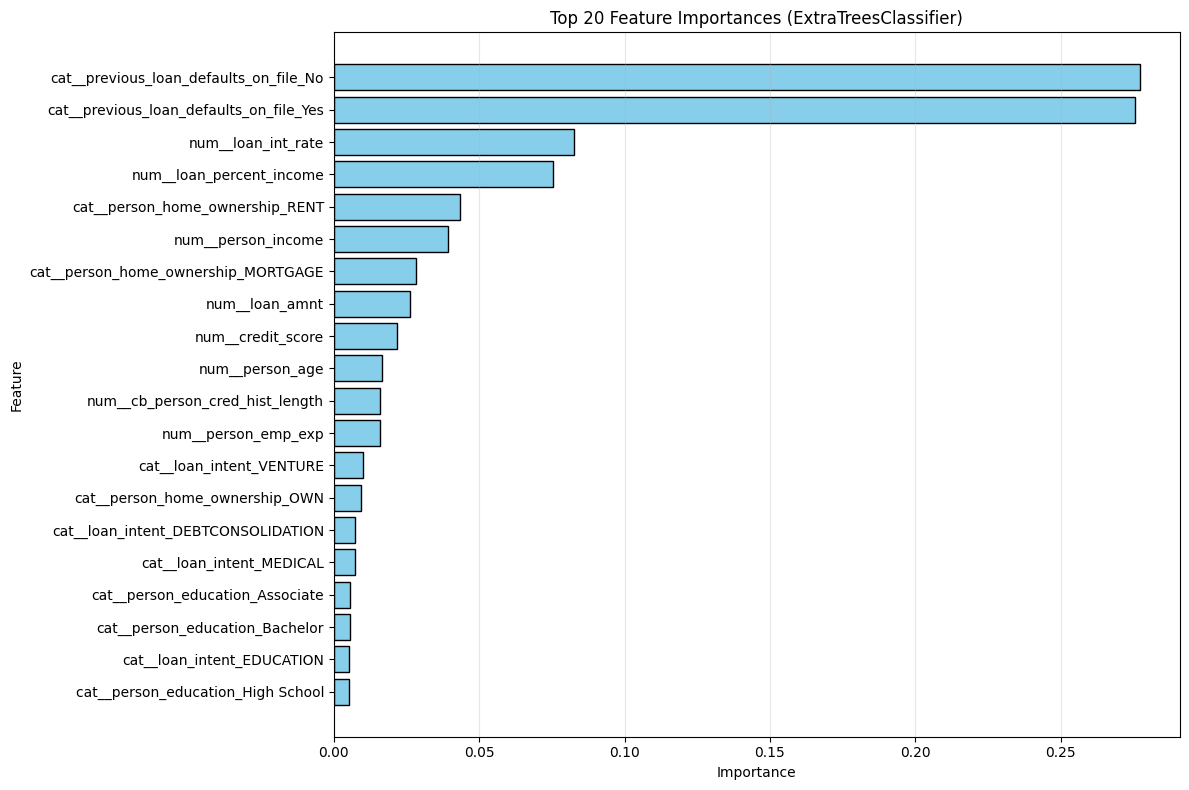

In [62]:
# Importance des features pour ExtraTreesClassifier

# Obtenir les noms des features après transformation (utiliser le preprocessor du modèle entraîné)
feature_names = best_etc.named_steps['preprocessor'].get_feature_names_out()

# Obtenir les importances des features
feature_importances = best_etc.named_steps['clf'].feature_importances_

# Créer un DataFrame pour faciliter le tri et la visualisation
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Afficher les 20 features les plus importantes
print("Top 20 features les plus importantes (ExtraTreesClassifier) :")
print(importance_df.head(20).to_string(index=False))

# Graphique des importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20], color='skyblue', edgecolor='black')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances (ExtraTreesClassifier)')
plt.gca().invert_yaxis()  # Inverser pour avoir la plus importante en haut
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Pipeline avec LightGBM

## LightGBM (Light Gradient Boosting Machine)

LightGBM est un algorithme de boosting basé sur les arbres de décision qui utilise une approche de croissance **leaf-wise (par feuille)** plutôt que level-wise, permettant une meilleure précision avec moins de calcul. Il emploie des techniques d'échantillonnage (**GOSS** et **EFB**) pour gérer les grands jeux de données efficacement.

**Formule de boosting :**

$$
F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)
$$

où $F_m(x)$ est le modèle à l'itération $m$, $\eta$ est le taux d'apprentissage, et $h_m(x)$ est l'arbre faible.

**Fonction de perte :**

$$
\mathcal{L}(F) = \sum_{i=1}^n l(y_i, F(x_i)) + \Omega(F)
$$

où $l$ est la perte (ex. : log-loss pour classification), et $\Omega(F)$ est un terme de régularisation.

**Gradient One-Side Sampling (GOSS) :**

Sélectionne les échantillons avec les gradients les plus grands et un sous-échantillon aléatoire des petits gradients pour approximer la distribution :

$$
\tilde{\mathcal{D}} = \mathcal{D}_{\text{large}} \cup \mathcal{D}_{\text{small}}^{\text{sampled}}
$$

**Exclusive Feature Bundling (EFB) :**

Regroupe les features mutuellement exclusives pour réduire la dimensionalité :

$$
\text{Bundle}(f_1, f_2) = \arg\min_{c} \sum_{i} |f_1^i - f_2^i - c|
$$


In [63]:
from lightgbm import LGBMClassifier

# Pipeline avec LightGBM (pas besoin de libomp !)
pipe_lgbm = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', LGBMClassifier(random_state=42, verbose=-1, n_jobs=1))
])

# GridSearch pour LightGBM
param_grid_lgbm = {
    'clf__n_estimators': [300, 500],
    'clf__max_depth': [5, 10, 30],
    'clf__learning_rate': [0.01,0.05, 0.1],
    'clf__subsample': [0.5, 0.8]
}

gs_lgbm = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_lgbm.fit(X_train, y_train)

print('Best params:', gs_lgbm.best_params_)
best_lgbm = gs_lgbm.best_estimator_

# Évaluation sur test
y_pred_lgbm = best_lgbm.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_lgbm))
print('\nClassification report:\n', classification_report(y_test, y_pred_lgbm))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__n_estimators': 500, 'clf__subsample': 0.5}
Test accuracy: 0.905

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      2000
           1       0.90      0.92      0.91      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.90      4000
weighted avg       0.91      0.91      0.90      4000



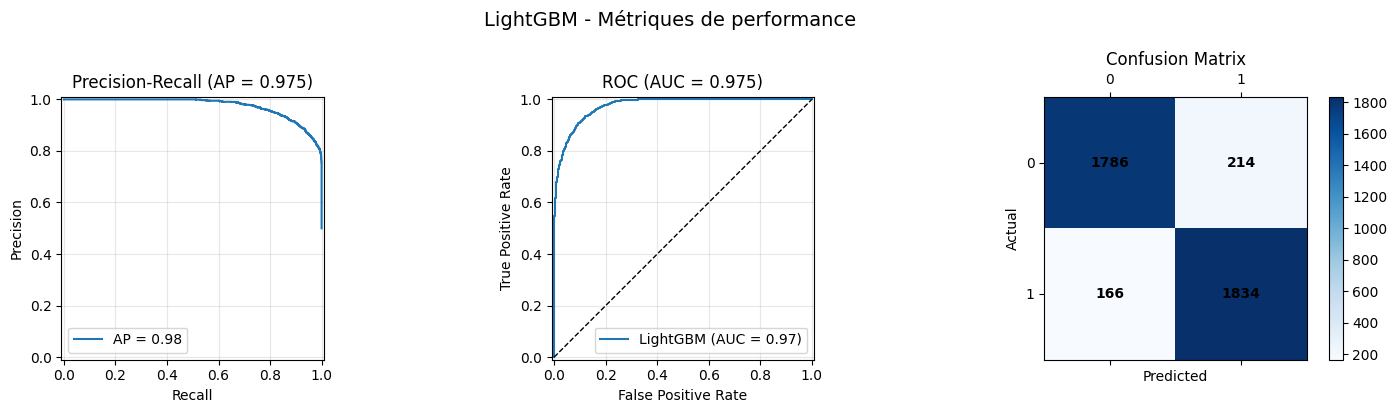

In [64]:
# Visualisation complète pour LightGBM : PR, ROC, Confusion Matrix

# Calculer les probabilités prédites
y_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

# Créer les 3 graphiques
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Courbe Precision-Recall
precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_proba_lgbm)
ap_lgbm = average_precision_score(y_test, y_proba_lgbm)
display_pr_lgbm = PrecisionRecallDisplay(precision=precision_lgbm, recall=recall_lgbm, average_precision=ap_lgbm)
display_pr_lgbm.plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP = {ap_lgbm:.3f})')
axes[0].grid(alpha=0.3)

# 2. Courbe ROC
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_proba_lgbm)
display_roc_lgbm = RocCurveDisplay(fpr=fpr_lgbm, tpr=tpr_lgbm, roc_auc=roc_auc_lgbm, estimator_name='LightGBM')
display_roc_lgbm.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC = {roc_auc_lgbm:.3f})')
axes[1].grid(alpha=0.3)

# 3. Matrice de confusion
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
cax = axes[2].matshow(cm_lgbm, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_lgbm):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.suptitle('LightGBM - Métriques de performance', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Top 20 features les plus importantes (LightGBM) :
                               feature  importance
                    num__person_income        2422
                    num__loan_int_rate        1847
                     num__credit_score        1154
              num__loan_percent_income         985
                        num__loan_amnt         957
                       num__person_age         689
                   num__person_emp_exp         503
       num__cb_person_cred_hist_length         434
       cat__person_home_ownership_RENT         221
        cat__person_home_ownership_OWN         198
              cat__loan_intent_VENTURE         191
              cat__loan_intent_MEDICAL         168
cat__previous_loan_defaults_on_file_No         153
      cat__loan_intent_HOMEIMPROVEMENT         145
    cat__loan_intent_DEBTCONSOLIDATION         136
   cat__person_home_ownership_MORTGAGE         125
             cat__loan_intent_PERSONAL         106
            cat__loan_intent_EDU

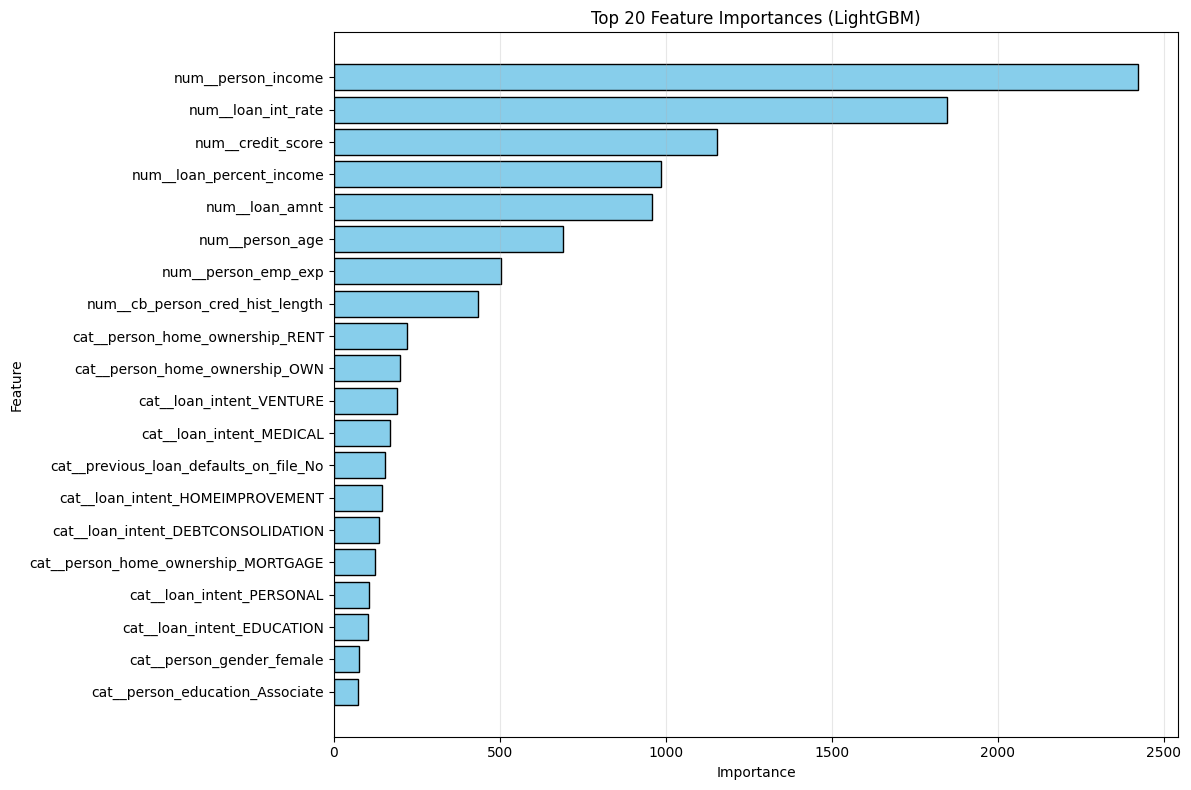

In [65]:
# Importance des features pour LightGBM

# Obtenir les noms des features après transformation (utiliser le preprocessor du modèle entraîné)
feature_names = best_lgbm.named_steps['preprocessor'].get_feature_names_out()

# Obtenir les importances des features
feature_importances = best_lgbm.named_steps['clf'].feature_importances_

# Créer un DataFrame pour faciliter le tri et la visualisation
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Afficher les 20 features les plus importantes
print("Top 20 features les plus importantes (LightGBM) :")
print(importance_df.head(20).to_string(index=False))

# Graphique des importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20], color='skyblue', edgecolor='black')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.gca().invert_yaxis()  # Inverser pour avoir la plus importante en haut
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Pipeline avec XGBoost

## XGBoost (eXtreme Gradient Boosting)

XGBoost est un algorithme de boosting optimisé qui améliore les arbres de décision en ajoutant des termes de **régularisation** et en utilisant une **optimisation de second ordre** (Taylor). Il gère efficacement les valeurs manquantes et offre une parallélisation avancée.

**Formule de boosting :**

$$
\hat{y}_i = \sum_{k=1}^K f_k(x_i), \quad f_k \in \mathcal{F}
$$

où $\mathcal{F}$ est l'espace des arbres de décision.

**Fonction objectif :**

$$
\mathcal{L}^{(t)} = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t)
$$

avec $\Omega(f) = \gamma T + \frac{1}{2} \lambda \|w\|^2$, où $T$ est le nombre de feuilles, $w$ les poids des feuilles.

**Approximation de second ordre (Taylor) :**

$$
\mathcal{L}^{(t)} \approx \sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t)
$$

où $g_i = \partial_{\hat{y}^{(t-1)}} l(y_i, \hat{y}^{(t-1)})$, $h_i = \partial_{\hat{y}^{(t-1)}}^2 l(y_i, \hat{y}^{(t-1)})$.

**Gain de division :**

$$
\text{Gain} = \frac{1}{2} \left[ \frac{(\sum_{i \in I_L} g_i)^2}{\sum_{i \in I_L} h_i + \lambda} + \frac{(\sum_{i \in I_R} g_i)^2}{\sum_{i \in I_R} h_i + \lambda} - \frac{(\sum_{i \in I} g_i)^2}{\sum_{i \in I} h_i + \lambda} \right] - \gamma
$$

In [66]:
from xgboost import XGBClassifier

# Pipeline avec XGBoost (sans restriction de thread)
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# GridSearch avec parallélisme complet
param_grid_xgb = {
    'clf__n_estimators': [200, 500],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [ 0.3, 0.5, 0.8, 1],
    'clf__subsample': [0.8, 1.0]
}

# n_jobs=-1 utilise tous les cœurs CPU
gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_xgb.fit(X_train, y_train)

print('Best params:', gs_xgb.best_params_)
best_xgb = gs_xgb.best_estimator_

# Évaluation sur test
y_pred_xgb = best_xgb.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_xgb))
print('\nClassification report:\n', classification_report(y_test, y_pred_xgb))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 500, 'clf__subsample': 1.0}
Test accuracy: 0.90425

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      2000
           1       0.90      0.91      0.91      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



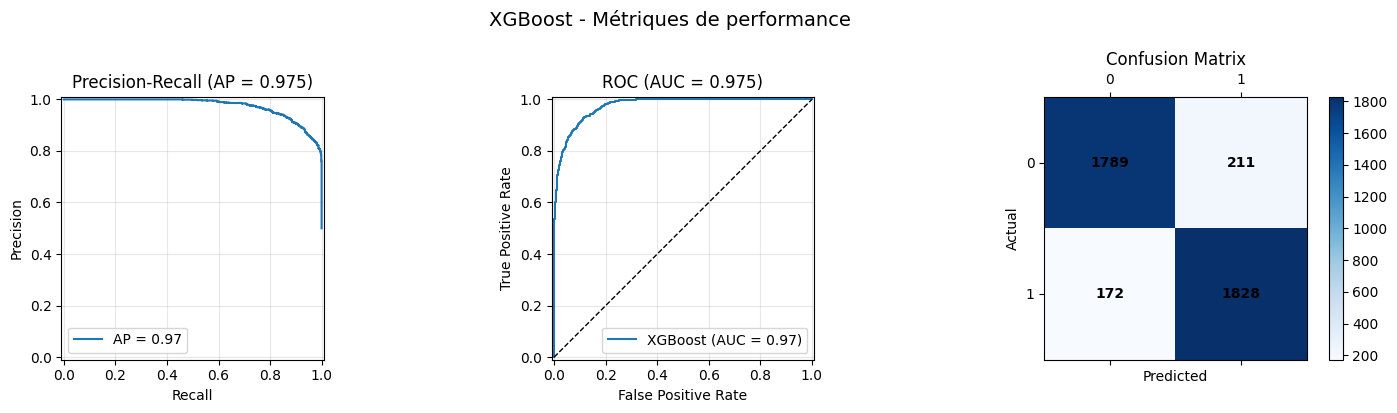

In [67]:
# Visualisation complète pour XGBoost : PR, ROC, Confusion Matrix

# Calculer les probabilités prédites
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Créer les 3 graphiques
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Courbe Precision-Recall
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
ap_xgb = average_precision_score(y_test, y_proba_xgb)
display_pr_xgb = PrecisionRecallDisplay(precision=precision_xgb, recall=recall_xgb, average_precision=ap_xgb)
display_pr_xgb.plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP = {ap_xgb:.3f})')
axes[0].grid(alpha=0.3)

# 2. Courbe ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
display_roc_xgb = RocCurveDisplay(fpr=fpr_xgb, tpr=tpr_xgb, roc_auc=roc_auc_xgb, estimator_name='XGBoost')
display_roc_xgb.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC = {roc_auc_xgb:.3f})')
axes[1].grid(alpha=0.3)

# 3. Matrice de confusion
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cax = axes[2].matshow(cm_xgb, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_xgb):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.suptitle('XGBoost - Métriques de performance', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Adaboost

## AdaBoost (Adaptive Boosting)

AdaBoost est un algorithme de boosting qui ajuste itérativement les poids des échantillons d'entraînement pour se concentrer sur les erreurs précédentes. Il combine plusieurs classifieurs faibles (souvent des arbres de décision simples) en une prédiction forte.

**Formule de prédiction :**

$$
\hat{y}(x) = \text{sign}\left( \sum_{t=1}^T \alpha_t h_t(x) \right)
$$

où $h_t$ est le classifieur faible à l'itération $t$, et $\alpha_t$ est son poids.

**Calcul des poids des classifieurs :**

$$
\alpha_t = \frac{1}{2} \ln\left( \frac{1 - \epsilon_t}{\epsilon_t} \right)
$$

où $\epsilon_t$ est le taux d'erreur pondéré du classifieur $h_t$.

**Mise à jour des poids des échantillons :**

$$
w_{t+1,i} = w_{t,i} \exp(-\alpha_t y_i h_t(x_i))
$$

normalisé pour que $\sum w_{t+1,i} = 1$.

**Erreur pondérée :**

$$
\epsilon_t = \sum_{i=1}^n w_{t,i} I(y_i \neq h_t(x_i))
$$

In [68]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Pipeline avec AdaBoost
pipe_ada = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', AdaBoostClassifier(random_state=42))
])

# GridSearch pour AdaBoost
param_grid_ada = {
    'clf__n_estimators': [300, 500, 700],
    'clf__learning_rate': [ 1.0, 1.5, 2],
    'clf__estimator': [
        DecisionTreeClassifier(max_depth=3),
        DecisionTreeClassifier(max_depth=4),
        DecisionTreeClassifier(max_depth=5)
    ]
}

gs_ada = GridSearchCV(pipe_ada, param_grid_ada, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_ada.fit(X_train, y_train)

print('Best params:', gs_ada.best_params_)
best_ada = gs_ada.best_estimator_

# Évaluation
y_pred_ada = best_ada.predict(X_test)
y_proba_ada = best_ada.predict_proba(X_test)[:, 1]

print(f'Test accuracy: {accuracy_score(y_test, y_pred_ada):.4f}')
print(f'Test F1-score: {f1_score(y_test, y_pred_ada):.4f}')
print('\nClassification report:\n', classification_report(y_test, y_pred_ada))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'clf__estimator': DecisionTreeClassifier(max_depth=3), 'clf__learning_rate': 1.0, 'clf__n_estimators': 700}
Test accuracy: 0.9005
Test F1-score: 0.9011

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      2000
           1       0.90      0.91      0.90      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



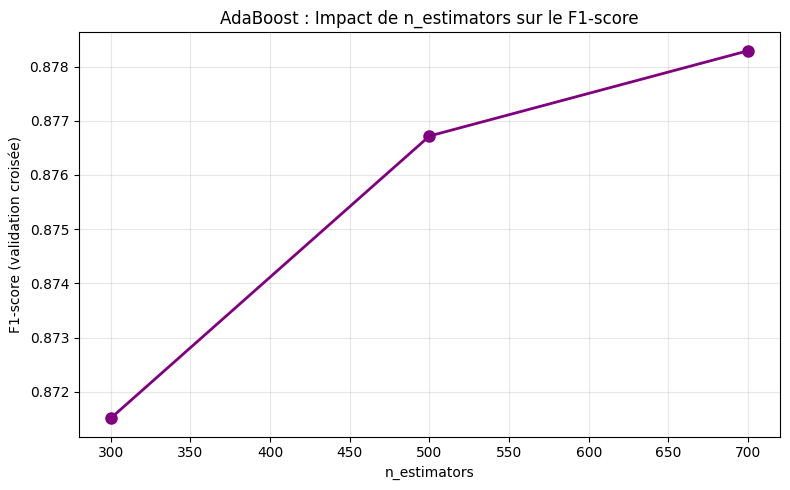


AdaBoost - F1-score moyen par n_estimators :
  • n_estimators=300: F1=0.8715
  • n_estimators=500: F1=0.8767
  • n_estimators=700: F1=0.8783


In [69]:
# Analyser l'impact de n_estimators sur AdaBoost
cv_results_ada = pd.DataFrame(gs_ada.cv_results_)

# Extraire les valeurs uniques
n_ests_ada = sorted(cv_results_ada['param_clf__n_estimators'].unique())
learning_rates_ada = sorted(cv_results_ada['param_clf__learning_rate'].unique())

# Calculer la moyenne du F1-score pour chaque n_estimators (moyenne sur les autres hyperparamètres)
means_n_ada = []
for n_est in n_ests_ada:
    mask = cv_results_ada['param_clf__n_estimators'] == n_est
    data = cv_results_ada[mask]['mean_test_score'].values
    means_n_ada.append(data.mean())

# Graphique
plt.figure(figsize=(8, 5))
plt.plot(n_ests_ada, means_n_ada, 'o-', linewidth=2, markersize=8, color='purple')
plt.xlabel('n_estimators')
plt.ylabel('F1-score (validation croisée)')
plt.title('AdaBoost : Impact de n_estimators sur le F1-score')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Afficher les valeurs
print("\nAdaBoost - F1-score moyen par n_estimators :")
for n_est, mean_f1 in zip(n_ests_ada, means_n_ada):
    print(f"  • n_estimators={n_est}: F1={mean_f1:.4f}")

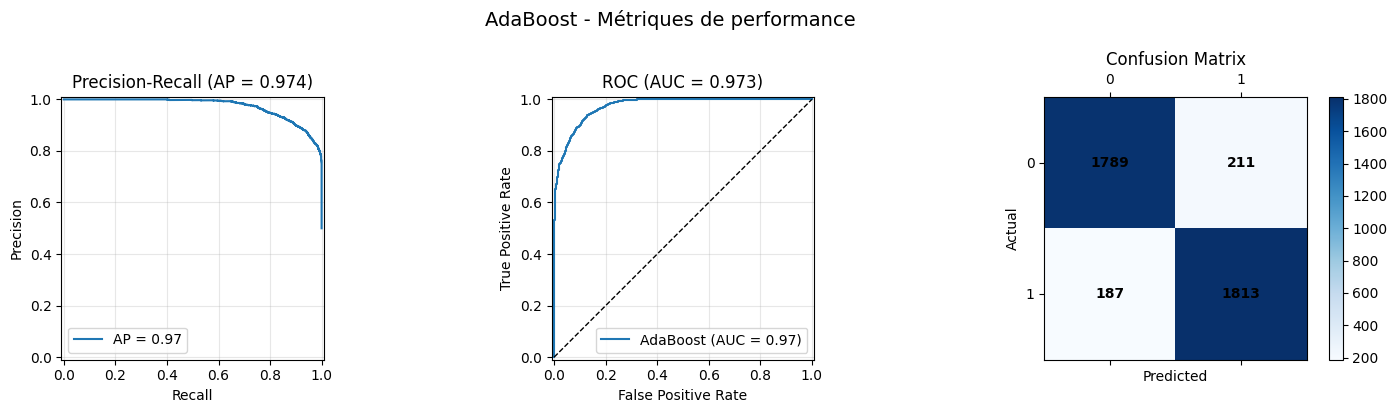

In [70]:
# Visualisation AdaBoost : PR, ROC, Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Precision-Recall
precision_ada, recall_ada, _ = precision_recall_curve(y_test, y_proba_ada)
ap_ada = average_precision_score(y_test, y_proba_ada)
PrecisionRecallDisplay(precision=precision_ada, recall=recall_ada, average_precision=ap_ada).plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP = {ap_ada:.3f})')
axes[0].grid(alpha=0.3)

# 2. ROC
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_proba_ada)
roc_auc_ada = roc_auc_score(y_test, y_proba_ada)
RocCurveDisplay(fpr=fpr_ada, tpr=tpr_ada, roc_auc=roc_auc_ada, estimator_name='AdaBoost').plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC = {roc_auc_ada:.3f})')
axes[1].grid(alpha=0.3)

# 3. Confusion Matrix
cm_ada = confusion_matrix(y_test, y_pred_ada)
cax = axes[2].matshow(cm_ada, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_ada):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.suptitle('AdaBoost - Métriques de performance', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## HistGradientClassifier

## HistGradientBoosting

**HistGradientBoosting** est une implémentation optimisée de **gradient boosting** qui utilise des **histogrammes** pour accélérer l'entraînement sur de grands jeux de données. Il gère nativement les valeurs manquantes et utilise des arbres binaires pour la classification.

**Formule de boosting :**

$$
F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)
$$

où $h_m(x)$ est un arbre de décision entraîné sur les résidus (pseudo-résidus ou gradients) et $\eta$ est le taux d'apprentissage.

**Fonction de perte :**

$$
\mathcal{L}(F) = \sum_{i=1}^n l(y_i, F(x_i))
$$

Pour la classification binaire, souvent la log-loss :

$$
l(y, F) = \log(1 + \exp(-2yF))
$$

**Optimisation par histogrammes :**

Les features sont discrétisées en histogrammes pour réduire le coût de calcul des divisions. Le calcul des statistiques (gradients $g_i$ et hessians $h_i$) pour chaque **bin** d'histogramme est :

$$
\text{Hist}_g(j, b) = \sum_{i: x_{i,j} \in \text{bin } b} g_i, \quad \text{Hist}_h(j, b) = \sum_{i: x_{i,j} \in \text{bin } b} h_i
$$

où $j$ est l'index de la feature et $b$ est le *bin* (compartiment) de l'histogramme.

**Gain de division :**

Le critère de gain (lié à la réduction de la perte) lors d'une division est approximé en utilisant les sommes des gradients et des hessians des bins gauche ($L$) et droit ($R$) :

$$
\text{Gain} = \frac{(\sum_{i \in L} g_i)^2}{\sum_{i \in L} h_i} + \frac{(\sum_{i \in R} g_i)^2}{\sum_{i \in R} h_i} - \frac{(\sum_{i} g_i)^2}{\sum_{i} h_i}
$$

Fitting 5 folds for each of 54 candidates, totalling 270 fits


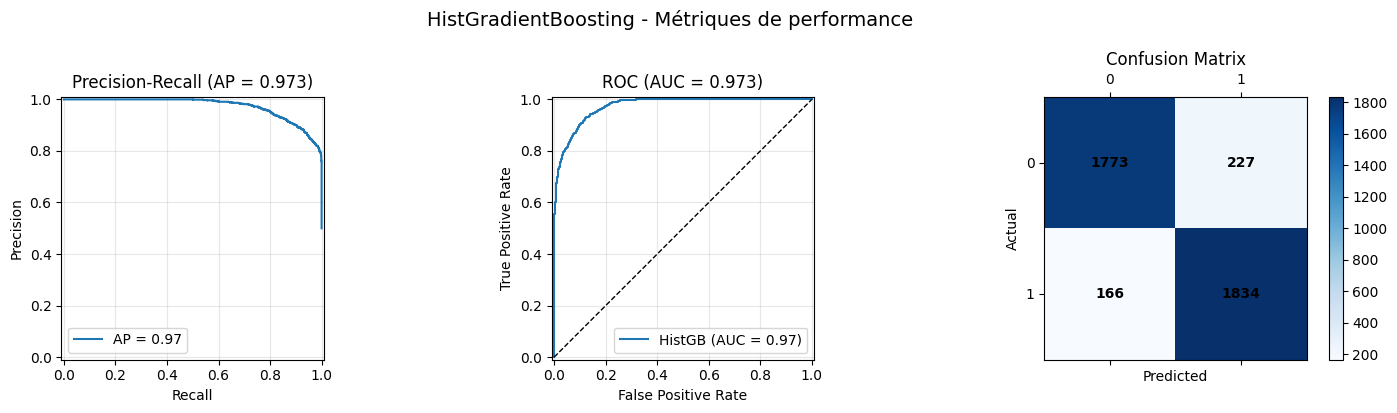

In [71]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Pipeline avec HistGradientBoostingClassifier
pipe_hgb = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', HistGradientBoostingClassifier(random_state=42))
])

# Grille d'hyperparamètres
param_grid_hgb = {
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_iter': [300, 500],
    'clf__max_depth': [3, 5, 7],
    'clf__l2_regularization': [0, 1, 10]
}

gs_hgb = GridSearchCV(
    pipe_hgb,
    param_grid=param_grid_hgb,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
gs_hgb.fit(X_train, y_train)
best_hgb = gs_hgb.best_estimator_
y_pred_hgb = best_hgb.predict(X_test)
y_proba_hgb = best_hgb.predict_proba(X_test)[:, 1]

# Visualisation : PR, ROC, Matrice de confusion
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Precision-Recall
precision_hgb, recall_hgb, _ = precision_recall_curve(y_test, y_proba_hgb)
ap_hgb = average_precision_score(y_test, y_proba_hgb)
PrecisionRecallDisplay(precision=precision_hgb, recall=recall_hgb, average_precision=ap_hgb).plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP = {ap_hgb:.3f})')
axes[0].grid(alpha=0.3)

# ROC
fpr_hgb, tpr_hgb, _ = roc_curve(y_test, y_proba_hgb)
roc_auc_hgb = roc_auc_score(y_test, y_proba_hgb)
RocCurveDisplay(fpr=fpr_hgb, tpr=tpr_hgb, roc_auc=roc_auc_hgb, estimator_name='HistGB').plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC = {roc_auc_hgb:.3f})')
axes[1].grid(alpha=0.3)

# Matrice de confusion
cm_hgb = confusion_matrix(y_test, y_pred_hgb)
cax = axes[2].matshow(cm_hgb, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_hgb):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.suptitle('HistGradientBoosting - Métriques de performance', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Vérification de la cohérence des scores et des erreurs des modèles.

On vérifie si les erreurs sur les prédictions sont les même ou si elles varient suivant les modèles

                      Precision  Recall        F1
Model                                            
Logistic Regression    0.839557  0.9105  0.873591
Random Forest          0.875655  0.9190  0.896804
Extra Trees            0.844233  0.9295  0.884817
LightGBM               0.895508  0.9170  0.906126
XGBoost                0.896518  0.9140  0.905175
AdaBoost               0.895751  0.9065  0.901093
HistGradientBoosting   0.889859  0.9170  0.903226
Total Faux Positifs (tous modèles cumulés) : 1815
Total Faux Négatifs (tous modèles cumulés) : 1173


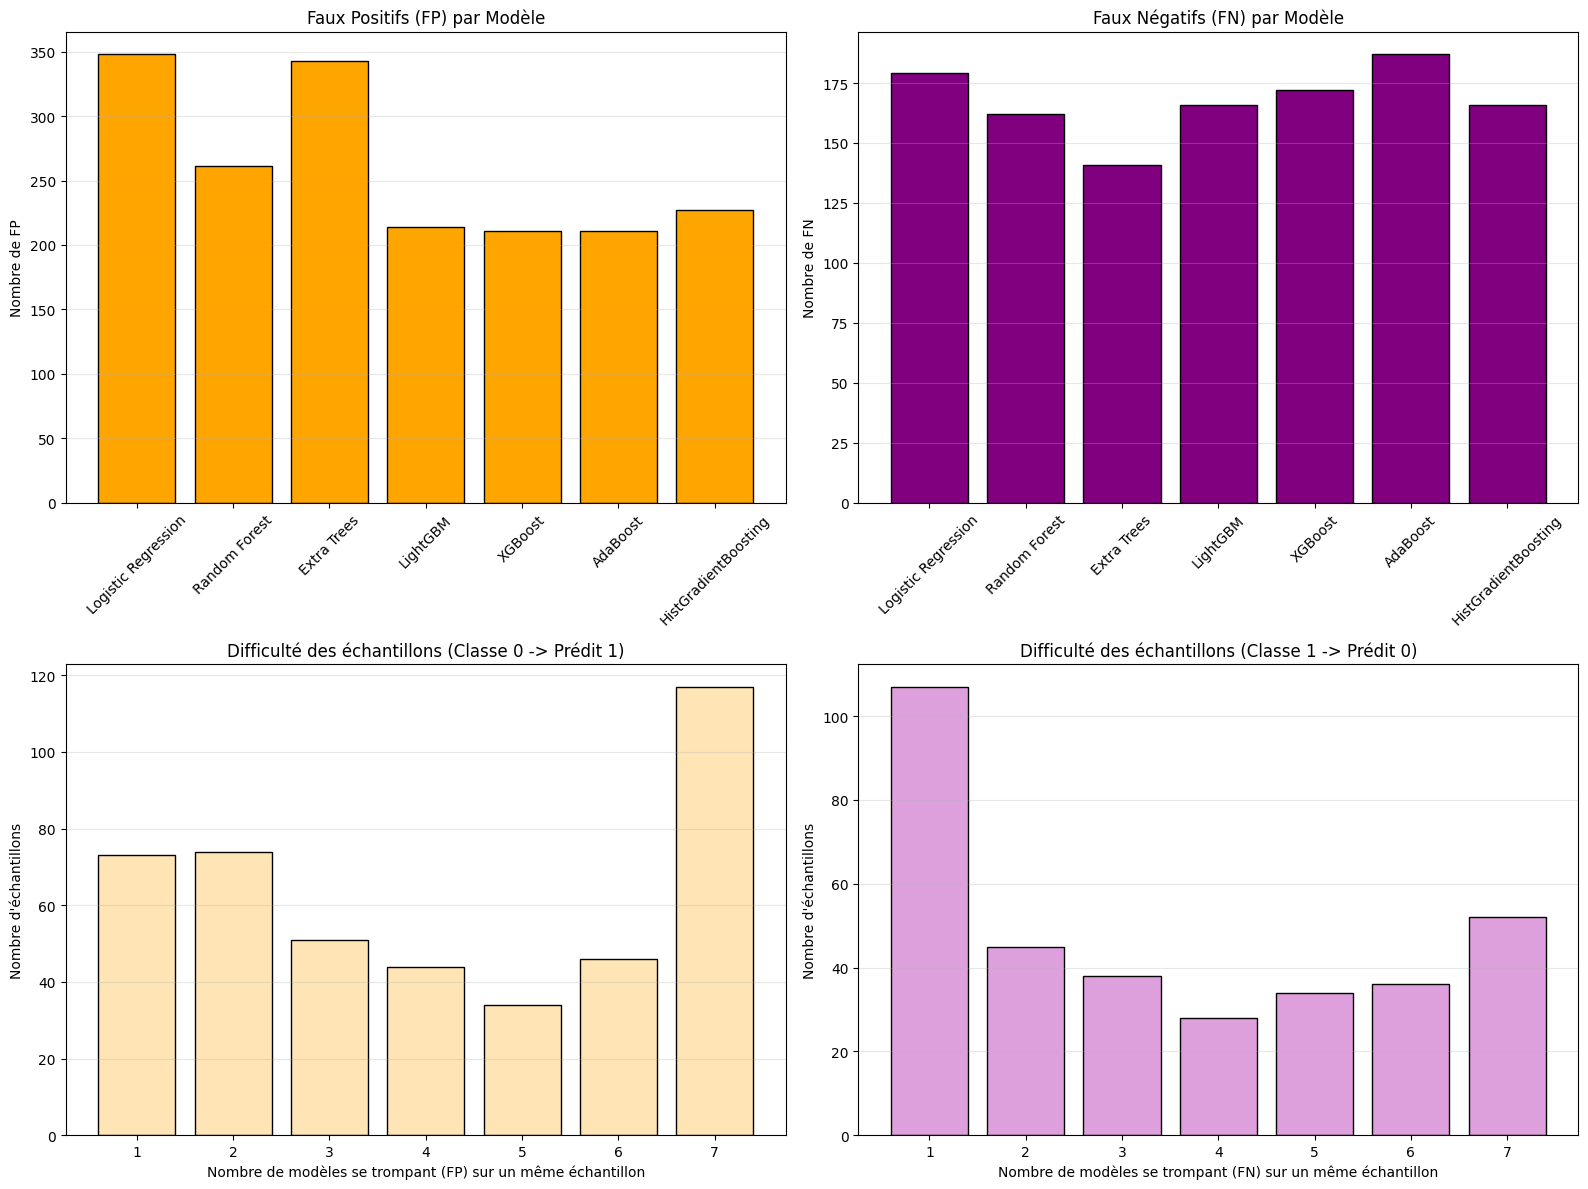

In [72]:

models = {
    'Logistic Regression': best_lr.predict(X_test),
    'Random Forest': best_rf.predict(X_test),
    'Extra Trees': best_etc.predict(X_test),
    'LightGBM': best_lgbm.predict(X_test),
    'XGBoost': best_xgb.predict(X_test),
    'AdaBoost': best_ada.predict(X_test),
    'HistGradientBoosting': best_hgb.predict(X_test)
}

# Création du DataFrame des métriques
metrics_data = []
for name, preds in models.items():
    metrics_data.append({
        'Model': name,
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1': f1_score(y_test, preds)
    })

df_metrics = pd.DataFrame(metrics_data).set_index('Model')
print(df_metrics)

# 1. Calculer FP et FN par modèle
fp_by_model = {}
fn_by_model = {}

for name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    # cm structure: [[TN, FP], [FN, TP]]
    fp_by_model[name] = cm[0, 1]
    fn_by_model[name] = cm[1, 0]

# 2. Calculer les erreurs par échantillon (Sample-wise)
# On initialise des compteurs de zéros
fp_counts_per_sample = np.zeros(len(y_test))
fn_counts_per_sample = np.zeros(len(y_test))

# On s'assure que y_test est un array numpy pour les masques
y_test_arr = np.array(y_test)

for name, y_pred in models.items():
    # Faux Positifs : Le modèle prédit 1 alors que c'est 0
    fp_mask = (y_pred == 1) & (y_test_arr == 0)
    fp_counts_per_sample[fp_mask] += 1
    
    # Faux Négatifs : Le modèle prédit 0 alors que c'est 1
    fn_mask = (y_pred == 0) & (y_test_arr == 1)
    fn_counts_per_sample[fn_mask] += 1

# Prints simples pour info
print(f"Total Faux Positifs (tous modèles cumulés) : {sum(fp_by_model.values())}")
print(f"Total Faux Négatifs (tous modèles cumulés) : {sum(fn_by_model.values())}")

# --- VISUALISATION 2x2 ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# HAUT GAUCHE : FP par Modèle
axes[0, 0].bar(fp_by_model.keys(), fp_by_model.values(), color='orange', edgecolor='black')
axes[0, 0].set_title('Faux Positifs (FP) par Modèle')
axes[0, 0].set_ylabel('Nombre de FP')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# HAUT DROITE : FN par Modèle
axes[0, 1].bar(fn_by_model.keys(), fn_by_model.values(), color='purple', edgecolor='black')
axes[0, 1].set_title('Faux Négatifs (FN) par Modèle')
axes[0, 1].set_ylabel('Nombre de FN')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# BAS GAUCHE : Distribution des FP par échantillon
# On ne garde que les échantillons qui sont réellement négatifs (0) et qui ont au moins une erreur
mask_fp = (y_test_arr == 0) & (fp_counts_per_sample > 0)
unique_fp, counts_fp = np.unique(fp_counts_per_sample[mask_fp], return_counts=True)

axes[1, 0].bar(unique_fp, counts_fp, color='moccasin', edgecolor='black')
axes[1, 0].set_xlabel('Nombre de modèles se trompant (FP) sur un même échantillon')
axes[1, 0].set_ylabel('Nombre d\'échantillons')
axes[1, 0].set_title('Difficulté des échantillons (Classe 0 -> Prédit 1)')
axes[1, 0].grid(axis='y', alpha=0.3)

# BAS DROITE : Distribution des FN par échantillon
# On ne garde que les échantillons qui sont réellement positifs (1) et qui ont au moins une erreur
mask_fn = (y_test_arr == 1) & (fn_counts_per_sample > 0)
unique_fn, counts_fn = np.unique(fn_counts_per_sample[mask_fn], return_counts=True)

axes[1, 1].bar(unique_fn, counts_fn, color='plum', edgecolor='black')
axes[1, 1].set_xlabel('Nombre de modèles se trompant (FN) sur un même échantillon')
axes[1, 1].set_ylabel('Nombre d\'échantillons')
axes[1, 1].set_title('Difficulté des échantillons (Classe 1 -> Prédit 0)')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Intuition : on peut faire en sorte que les modèles votent tous ensembles, permettant de supprimer les erreurs faites par 1, 2, 3 modèles puisque au moins 4 autres modèles ne font pas ces fautes.

## Création d'un algorithme de vote simple utilisant les 7 modèles précédents et en séparant FP et FN

=== HARD VOTING ENSEMBLE PERFORMANCE ===
Accuracy : 0.9022
F1-Score : 0.9044
Precision: 0.8847
Recall   : 0.9250


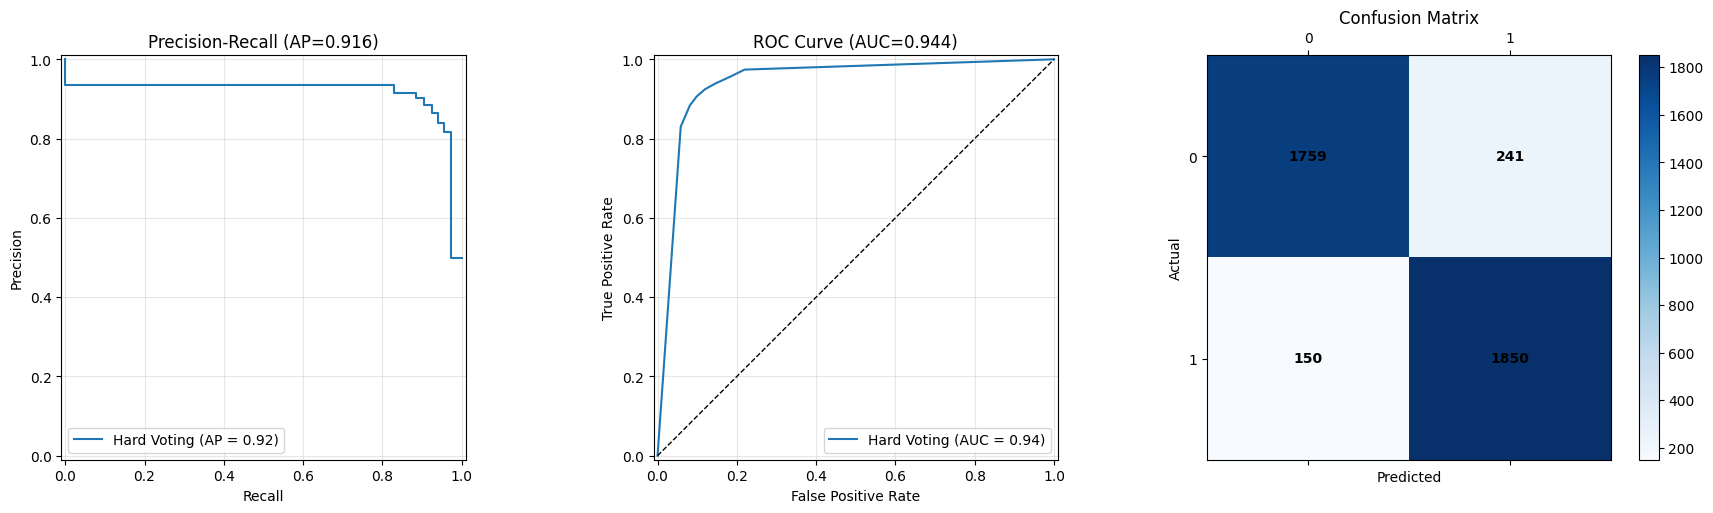

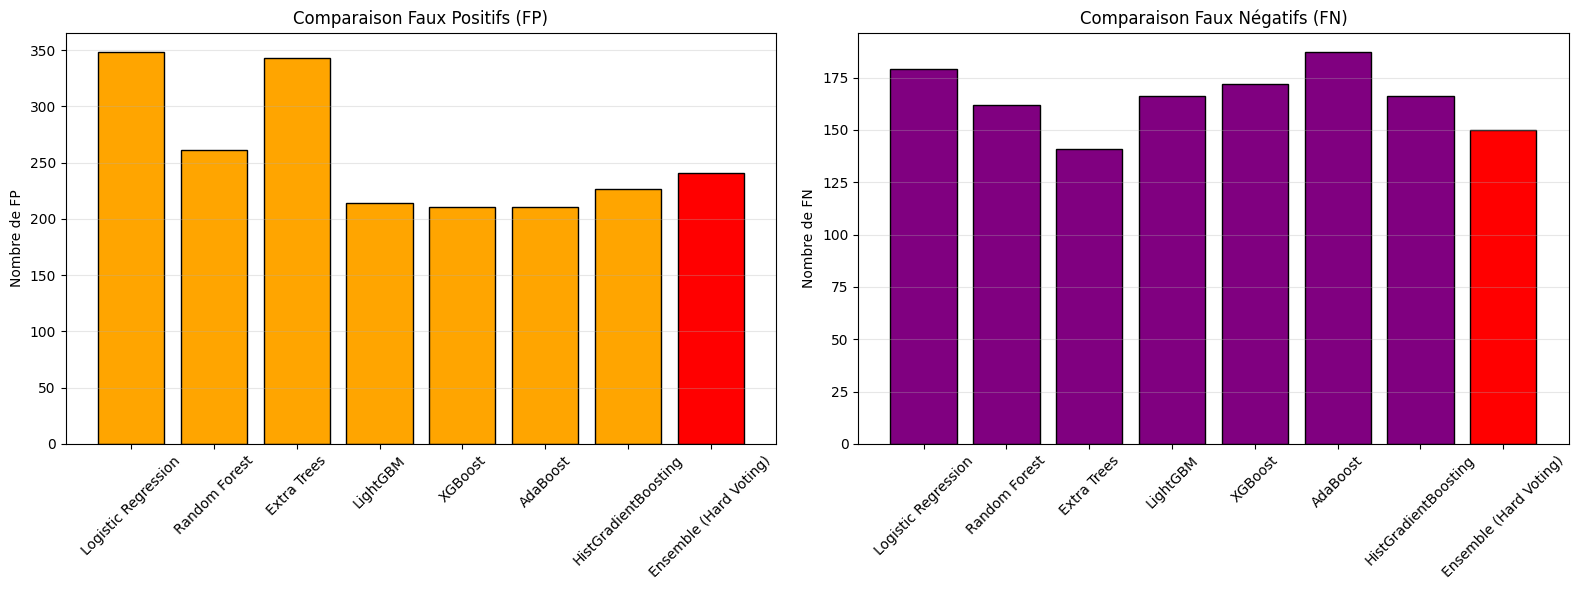

In [73]:

# --- 1. HARD VOTING ENSEMBLE ---

# Liste des modèles entraînés
estimators = [
    ('Logistic Regression', best_lr),
    ('Random Forest', best_rf),
    ('Extra Trees', best_etc),
    ('LightGBM', best_lgbm),
    ('XGBoost', best_xgb),
    ('AdaBoost', best_ada),
    ('HistGradientBoosting', best_hgb)
]

# Récupération des prédictions binaires de chaque modèle
all_preds = np.array([model.predict(X_test) for _, model in estimators])

# Vote majoritaire : si la moyenne des votes est >= 0.5, la classe est 1
y_pred_ensemble = (np.sum(all_preds, axis=0) > (len(estimators) / 2)).astype(int)

# Pour les courbes, on utilise la "fraction de votes positifs" comme pseudo-probabilité
y_proba_ensemble = np.mean(all_preds, axis=0)

# Affichage des métriques textuelles
print("=== HARD VOTING ENSEMBLE PERFORMANCE ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred_ensemble):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred_ensemble):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_ensemble):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_ensemble):.4f}")

# --- 2. VISUALISATION PERFORMANCE (3 Subplots) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# A. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_ensemble)
ap = average_precision_score(y_test, y_proba_ensemble)
display_pr = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap)
display_pr.plot(ax=axes[0], name='Hard Voting')
axes[0].set_title(f'Precision-Recall (AP={ap:.3f})')
axes[0].grid(alpha=0.3)

# B. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_ensemble)
roc_auc = roc_auc_score(y_test, y_proba_ensemble)
display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Hard Voting')
display_roc.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC Curve (AUC={roc_auc:.3f})')
axes[1].grid(alpha=0.3)

# C. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
cax = axes[2].matshow(cm, cmap='Blues')
for (i, j), val in np.ndenumerate(cm):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.tight_layout()
plt.show()

# --- 3. COMPARAISON DES ERREURS (FP & FN) AVEC L'ENSEMBLE ---

# On reconstruit le dictionnaire des prédictions en ajoutant l'ensemble
models_preds = {name: model.predict(X_test) for name, model in estimators}
models_preds['Ensemble (Hard Voting)'] = y_pred_ensemble

# Calcul des FP et FN par modèle
fp_by_model = {}
fn_by_model = {}

for name, pred in models_preds.items():
    cm_curr = confusion_matrix(y_test, pred)
    fp_by_model[name] = cm_curr[0, 1]
    fn_by_model[name] = cm_curr[1, 0]

# Visualisation comparative
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))

# Graphique FP
colors_fp = ['orange'] * (len(fp_by_model)-1) + ['red'] # Rouge pour l'ensemble
axes2[0].bar(fp_by_model.keys(), fp_by_model.values(), color=colors_fp, edgecolor='black')
axes2[0].set_title('Comparaison Faux Positifs (FP)')
axes2[0].set_ylabel('Nombre de FP')
axes2[0].tick_params(axis='x', rotation=45, labelsize=10)
axes2[0].grid(axis='y', alpha=0.3)

# Graphique FN
colors_fn = ['purple'] * (len(fn_by_model)-1) + ['red'] # Rouge pour l'ensemble
axes2[1].bar(fn_by_model.keys(), fn_by_model.values(), color=colors_fn, edgecolor='black')
axes2[1].set_title('Comparaison Faux Négatifs (FN)')
axes2[1].set_ylabel('Nombre de FN')
axes2[1].tick_params(axis='x', rotation=45, labelsize=10)
axes2[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Nombre d'erreurs de l'Ensemble : 391


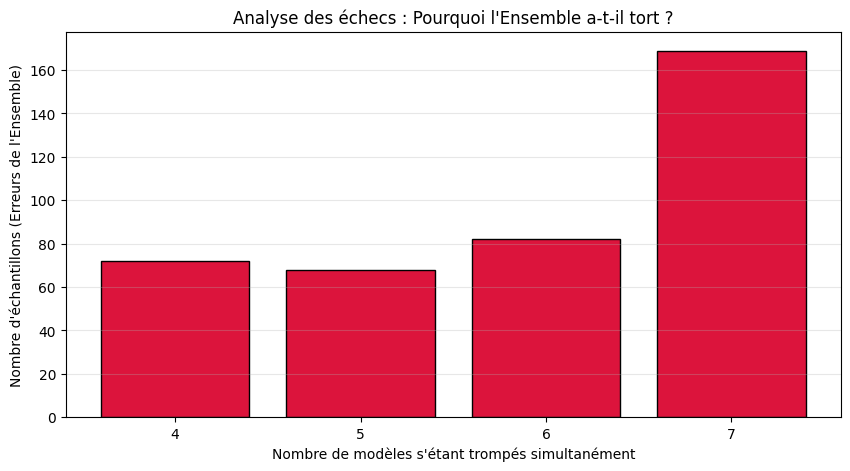


Qui tire l'ensemble vers le bas ?
(Pourcentage d'erreur du modèle quand l'ensemble se trompe)
HistGradientBoosting    0.877238
Random Forest           0.861893
LightGBM                0.856777
AdaBoost                0.854220
Extra Trees             0.828645
Logistic Regression     0.818414
XGBoost                 0.792839
dtype: float64


In [74]:


# 1. Récupérer les prédictions individuelles dans un DataFrame
df_preds = pd.DataFrame()
for name, model in estimators:
    df_preds[name] = model.predict(X_test)

# 2. Identifier UNIQUEMENT les cas où l'Ensemble s'est trompé
ensemble_errors_mask = (y_pred_ensemble != y_test.values)
X_errors = df_preds[ensemble_errors_mask]

# CORRECTION : On ajoute .values ici pour obtenir un tableau Numpy au lieu d'une Série avec index.
# Cela permet la comparaison avec X_errors (qui a un index différent) sans erreur.
y_true_errors = y_test.values[ensemble_errors_mask]

print(f"Nombre d'erreurs de l'Ensemble : {len(X_errors)}")

# 3. Sur ces erreurs, combien de modèles se sont trompés ?
# (Mathématiquement, ce sera forcément >= 4, sinon l'ensemble aurait eu juste)
nb_modeles_faux = X_errors.apply(lambda col: col != y_true_errors, axis=0).sum(axis=1)


# 4. Visualisation de la cause de l'échec
plt.figure(figsize=(10, 5))
counts = nb_modeles_faux.value_counts().sort_index()
bars = plt.bar(counts.index, counts.values, color='crimson', edgecolor='black')
plt.xlabel("Nombre de modèles s'étant trompés simultanément")
plt.ylabel("Nombre d'échantillons (Erreurs de l'Ensemble)")
plt.title("Analyse des échecs : Pourquoi l'Ensemble a-t-il tort ?")
plt.xticks(range(4, 8)) # On affiche 4, 5, 6, 7
plt.grid(axis='y', alpha=0.3)
plt.show()

# 5. Qui sont les coupables ? (Quels modèles se trompent le plus quand l'ensemble échoue ?)
error_rate_when_ensemble_fails = X_errors.apply(lambda col: col != y_true_errors, axis=0).mean()
print("\nQui tire l'ensemble vers le bas ?")
print("(Pourcentage d'erreur du modèle quand l'ensemble se trompe)")
print(error_rate_when_ensemble_fails.sort_values(ascending=False))

### Soft

Voting Ensemble - F1: 0.9014, Precision: 0.8763, Recall: 0.9280


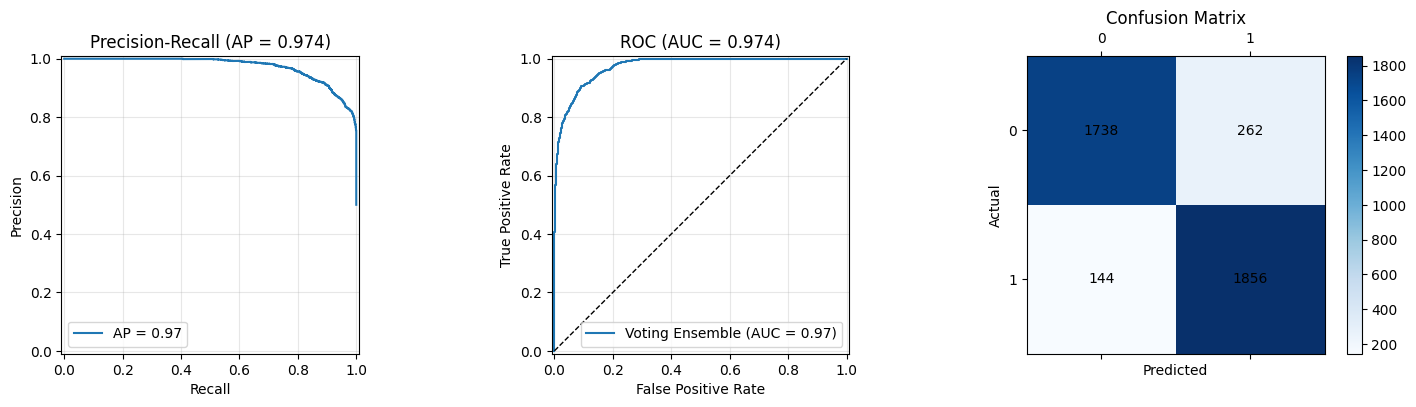

In [75]:
# Liste des modèles entraînés
models = [
    ('Logistic Regression', best_lr),
    ('Random Forest', best_rf),
    ('Extra Trees', best_etc),
    ('LightGBM', best_lgbm),
    ('XGBoost', best_xgb),
    ('AdaBoost', best_ada),
    ('HistGradientBoosting', best_hgb)
]

# Collecter les probabilités pour soft voting
proba_list = []
for name, model in models:
    proba = model.predict_proba(X_test)[:, 1]
    proba_list.append(proba)

# Moyenne des probabilités (soft voting)
y_proba_voting = np.mean(proba_list, axis=0)

# Prédictions binaires (seuil 0.5)
y_pred_voting = (y_proba_voting >= 0.5).astype(int)

# Métriques
f1 = f1_score(y_test, y_pred_voting)
precision = precision_score(y_test, y_pred_voting)
recall = recall_score(y_test, y_pred_voting)

print(f"Voting Ensemble - F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Visualisations comme pour Logistic Regression
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Courbe Precision-Recall
precision_v, recall_v, _ = precision_recall_curve(y_test, y_proba_voting)
ap_v = average_precision_score(y_test, y_proba_voting)
display_pr_v = PrecisionRecallDisplay(precision=precision_v, recall=recall_v, average_precision=ap_v)
display_pr_v.plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP = {ap_v:.3f})')
axes[0].grid(alpha=0.3)

# 2. Courbe ROC
fpr_v, tpr_v, _ = roc_curve(y_test, y_proba_voting)
roc_auc_v = roc_auc_score(y_test, y_proba_voting)
display_roc_v = RocCurveDisplay(fpr=fpr_v, tpr=tpr_v, roc_auc=roc_auc_v, estimator_name='Voting Ensemble')
display_roc_v.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC = {roc_auc_v:.3f})')
axes[1].grid(alpha=0.3)

# 3. Matrice de confusion
cm_v = confusion_matrix(y_test, y_pred_voting)
cax = axes[2].matshow(cm_v, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_v):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.tight_layout()
plt.show()

# Réseau de neurones (PyTorch)
Dans cette section, nous construisons un réseau de neurones entièrement connecté (*Multi-Layer Perceptron*) en utilisant PyTorch, afin de proposer une alternative plus flexible aux modèles classiques (Logistic Regression, SVM, KNN, etc.).

Métiel du pipeline :
- **GELU** : une activation plus performante que ReLU pour les réseaux profonds.  
- **Batch Normalization** : stabilise et accélère l'entraînement.  
- **Dropout** : régularisation légère pour réduire le surapprentissage.  
- **Skip Connection (résiduelle)** : améliore la propagation du gradient.  
- **Projection du skip** : permet d'additionner des tenseurs de dimensions différentes (128 → 64).  
- **Initialisation Kaiming/He** : adaptée aux activations GELU/LeakyReLU.  
- **Gradient Clipping** : évite l'exploding gradient.  
- **OneCycleLR** : scheduler moderne permettant une convergence plus rapide et plus stable.  
- **Early Stopping** : arrête l'entraînement dès que la perte ne s'améliore plus.


In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np

# ===================================================================
# 1) Préparation des données
# ===================================================================
X_train = X_train.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32)
X_test  = X_test.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32)

# Normalisation (fortement recommandé pour les MLP)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Conversion en tenseurs
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
y_test_t  = torch.tensor(y_test.values, dtype=torch.long)

# Split validation
X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(
    X_train_t, y_train_t, test_size=0.2, random_state=42
)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64, shuffle=False)


# ===================================================================
# 2) Modèle amélioré + skip connection + init
# ===================================================================
class DeepMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        self.skip_proj = nn.Linear(128, 64)
        self.output = nn.Linear(32, 2)

        self.apply(self._init_weights)

    def _init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, nonlinearity="leaky_relu")
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.layer1(x)
        skip = self.skip_proj(x)
        x = self.layer2(x) + skip
        x = self.layer3(x)
        return self.output(x)


mlp = DeepMLP(X_train.shape[1])

# ===================================================================
# 3) OPTIMIZER & SCHEDULER
# ===================================================================
optimizer = optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=1e-4)   # meilleure régularisation
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)    # descente douce et stable

criterion = nn.CrossEntropyLoss()

# ===================================================================
# 4) Entraînement avec validation + early stopping propre
# ===================================================================
best_val_loss = float("inf")
patience = 5
wait = 0

EPOCHS = 30

for epoch in range(EPOCHS):
    mlp.train()
    train_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = mlp(xb)
        loss = criterion(preds, yb)
        loss.backward()

        nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    scheduler.step()

    # ------- VALIDATION -------
    mlp.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            val_loss += criterion(mlp(xb), yb).item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

    # Early stopping → basé sur VALIDATION LOSS
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = mlp.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("\nEarly stopping activé \n")
            break

# Charger le meilleur modèle obtenu
mlp.load_state_dict(best_model)

# ===================================================================
# 5) Évaluation finale
# ===================================================================
mlp.eval()
with torch.no_grad():
    preds_test = mlp(X_test_t).argmax(1).numpy()

print("\nRésultats finaux\n")
print("Accuracy :", accuracy_score(y_test, preds_test))
print("\nMatrice de confusion:\n", confusion_matrix(y_test, preds_test))
print("\nClassification report:\n", classification_report(y_test, preds_test))


Epoch 1/30 | Train Loss: 0.5256 | Val Loss: 0.4845 | LR: 0.000994
Epoch 2/30 | Train Loss: 0.4994 | Val Loss: 0.4795 | LR: 0.000976
Epoch 3/30 | Train Loss: 0.4949 | Val Loss: 0.4770 | LR: 0.000946
Epoch 4/30 | Train Loss: 0.4901 | Val Loss: 0.4749 | LR: 0.000905
Epoch 5/30 | Train Loss: 0.4847 | Val Loss: 0.4743 | LR: 0.000854
Epoch 6/30 | Train Loss: 0.4818 | Val Loss: 0.4699 | LR: 0.000794
Epoch 7/30 | Train Loss: 0.4827 | Val Loss: 0.4714 | LR: 0.000727
Epoch 8/30 | Train Loss: 0.4808 | Val Loss: 0.4719 | LR: 0.000655
Epoch 9/30 | Train Loss: 0.4798 | Val Loss: 0.4705 | LR: 0.000578
Epoch 10/30 | Train Loss: 0.4806 | Val Loss: 0.4696 | LR: 0.000500
Epoch 11/30 | Train Loss: 0.4778 | Val Loss: 0.4683 | LR: 0.000422
Epoch 12/30 | Train Loss: 0.4765 | Val Loss: 0.4673 | LR: 0.000345
Epoch 13/30 | Train Loss: 0.4792 | Val Loss: 0.4686 | LR: 0.000273
Epoch 14/30 | Train Loss: 0.4746 | Val Loss: 0.4674 | LR: 0.000206
Epoch 15/30 | Train Loss: 0.4730 | Val Loss: 0.4659 | LR: 0.000146
Epoc

# Pytorch vs Ensemble hard voting

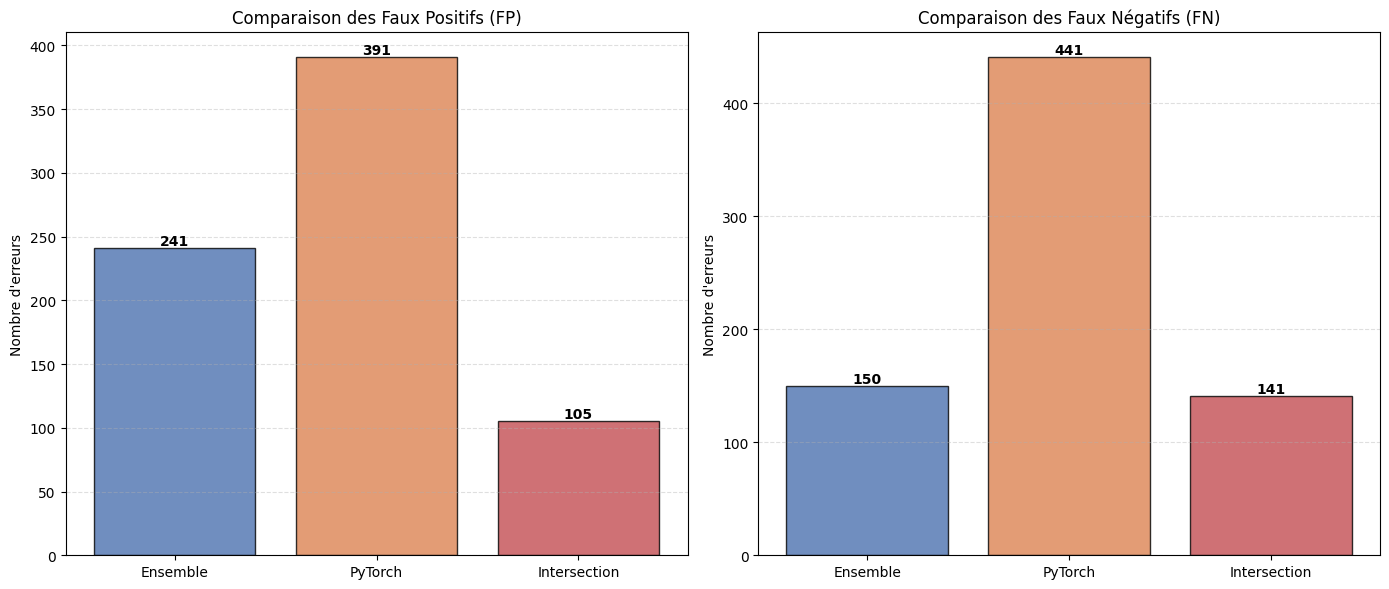

In [77]:
# Conversion explicite pour éviter les erreurs d'indexation
y_true_arr = y_test.values if hasattr(y_test, 'values') else y_test

# 1. Calcul des masques pour Faux Positifs (FP) : Prédit 1, Réel 0
fp_ensemble = (y_pred_ensemble == 1) & (y_true_arr == 0)
fp_pytorch = (preds_test == 1) & (y_true_arr == 0)
fp_common = fp_ensemble & fp_pytorch

# 2. Calcul des masques pour Faux Négatifs (FN) : Prédit 0, Réel 1
fn_ensemble = (y_pred_ensemble == 0) & (y_true_arr == 1)
fn_pytorch = (preds_test == 0) & (y_true_arr == 1)
fn_common = fn_ensemble & fn_pytorch

# 3. Préparation des données
labels = ['Ensemble', 'PyTorch', 'Intersection']
fp_counts = [fp_ensemble.sum(), fp_pytorch.sum(), fp_common.sum()]
fn_counts = [fn_ensemble.sum(), fn_pytorch.sum(), fn_common.sum()]

# 4. Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors = ['#4c72b0', '#dd8452', '#c44e52']  # Bleu, Orange, Rouge

# Histogramme FP
axes[0].bar(labels, fp_counts, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_title('Comparaison des Faux Positifs (FP)')
axes[0].set_ylabel('Nombre d\'erreurs')
axes[0].grid(axis='y', linestyle='--', alpha=0.4)
for i, v in enumerate(fp_counts):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Histogramme FN
axes[1].bar(labels, fn_counts, color=colors, edgecolor='black', alpha=0.8)
axes[1].set_title('Comparaison des Faux Négatifs (FN)')
axes[1].set_ylabel('Nombre d\'erreurs')
axes[1].grid(axis='y', linestyle='--', alpha=0.4)
for i, v in enumerate(fn_counts):
    axes[1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Soft voting final

=== HYBRID ENSEMBLE (Hard Voting Ensemble + PyTorch) ===
Accuracy : 0.8972
F1-Score : 0.8978
Precision: 0.8927
Recall   : 0.9030


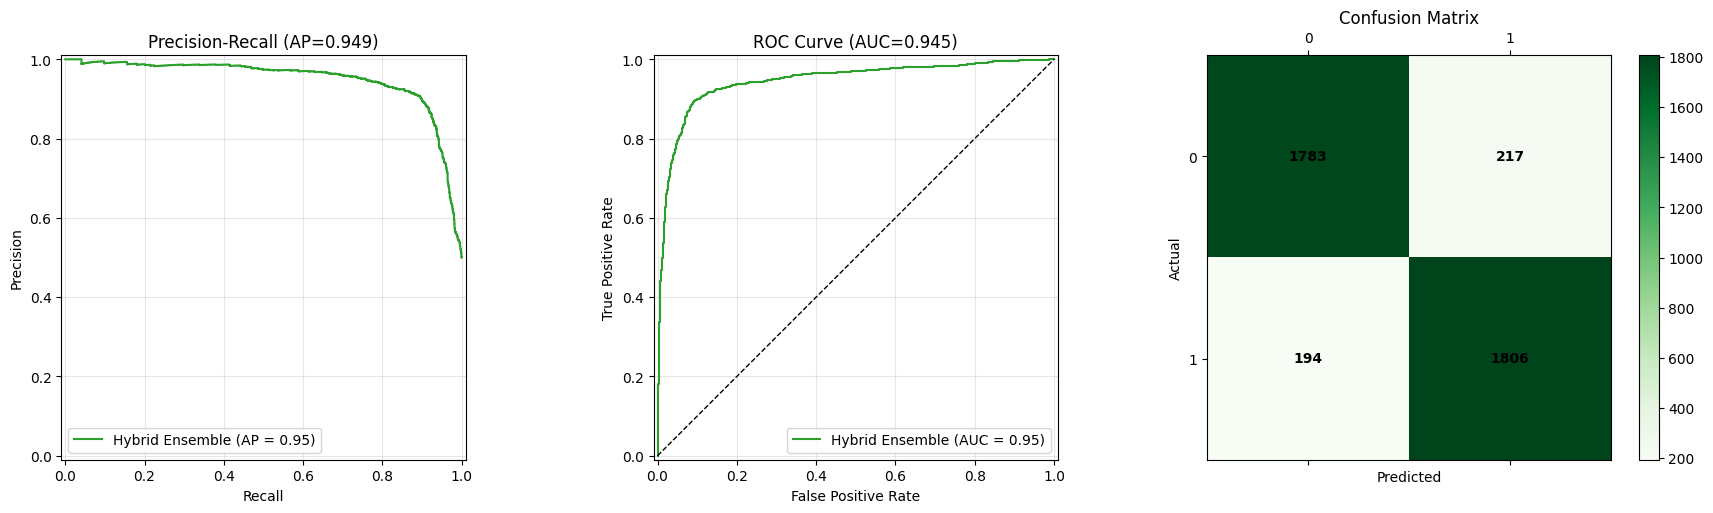

In [78]:
# 1. Récupération des probabilités du modèle PyTorch
mlp.eval()
with torch.no_grad():
    # On applique Softmax pour obtenir des probabilités [0, 1] au lieu des logits
    logits = mlp(X_test_t)
    probs_pytorch = torch.softmax(logits, dim=1)[:, 1].numpy()

# 2. Fusion des scores (Hybrid Soft Voting)
# Score Ensemble : Fraction des votes positifs (déjà calculé précédemment dans y_proba_ensemble)
# Score PyTorch : Probabilité issue du Softmax
# On fait la moyenne des deux signaux
final_proba = (y_proba_ensemble + probs_pytorch) / 2
final_pred = (final_proba >= 0.5).astype(int)

# 3. Évaluation des performances
print("=== HYBRID ENSEMBLE (Hard Voting Ensemble + PyTorch) ===")
print(f"Accuracy : {accuracy_score(y_test, final_pred):.4f}")
print(f"F1-Score : {f1_score(y_test, final_pred):.4f}")
print(f"Precision: {precision_score(y_test, final_pred):.4f}")
print(f"Recall   : {recall_score(y_test, final_pred):.4f}")

# 4. Visualisation professionnelle
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# A. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, final_proba)
ap = average_precision_score(y_test, final_proba)
display_pr = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap)
display_pr.plot(ax=axes[0], name='Hybrid Ensemble', color='#2ca02c')
axes[0].set_title(f'Precision-Recall (AP={ap:.3f})')
axes[0].grid(alpha=0.3)

# B. ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_proba)
roc_auc = roc_auc_score(y_test, final_proba)
display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Hybrid Ensemble')
display_roc.plot(ax=axes[1], color='#2ca02c')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC Curve (AUC={roc_auc:.3f})')
axes[1].grid(alpha=0.3)

# C. Confusion Matrix
cm = confusion_matrix(y_test, final_pred)
cax = axes[2].matshow(cm, cmap='Greens')
for (i, j), val in np.ndenumerate(cm):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.tight_layout()
plt.show()